In [2]:
import numpy as np
import xarray as xr
import xrft
import gsw
import os.path as op
import dask.array.fft as fft
from dask.diagnostics import ProgressBar
from oceanmodes import instability_analysis_from_N2_profile as insta
from oceanmodes import neutral_modes_from_N2_profile as neu
from scipy.interpolate import PchipInterpolator as pchip
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [3]:
ddir = '/swot/SUM05/takaya/MITgcm/channel/runs/'
avisodir = '/swot/SUM03/avisoftp.cnes.fr/AVISO/pub/jason-2/gdr_d'

In [4]:
# ys, dy = (35,23)
ys, dy = (38,20)
dt = 3e2
df = 288
ts = int((ys*360*86400)/dt)
te = int(ts + dy*360*86400/dt)
print(ts,te)

3939840 6013440


In [5]:
f0 = -1.1e-4
beta = 1.4e-11
g = 9.81
r0 = 1e3
alpha = 2e-4

In [6]:
dsnap = open_mdsdataset(op.join(ddir,'MOM-KPP_05km'), grid_dir=op.join(ddir,'5km_grid'),
                       iters=range(ts,te,4320), prefix=['MOMsnap'], delta_t=dt
                       )
dsnap

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (XC: 200, XG: 200, YC: 400, YG: 400, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 480)
Coordinates:
  * XC       (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * YC       (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * XG       (XG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * YG       (YG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * Zp1      (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zu       (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 -16.1 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    rA       (YC, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    dxG      (YG, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    dyG      (YC, XG) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    Depth    (YC,

In [7]:
u = dsnap.UVEL
v = dsnap.VVEL
w = dsnap.WVEL

In [8]:
grid = Grid(dsnap, periodic=['X'])
phi = dsnap.PHIHYD
b = (grid.diff(phi,'Z',boundary='fill')/grid.diff(phi.Z,'Z',boundary='fill'))
b

<xarray.DataArray (time: 480, Zl: 76, YC: 400, XC: 200)>
dask.array<shape=(480, 76, 400, 200), dtype=float32, chunksize=(1, 1, 400, 200)>
Coordinates:
  * time     (time) float64 1.182e+09 1.183e+09 1.185e+09 1.186e+09 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * YC       (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * XC       (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...

## $$F_s = \mathbf{Q}_s\cdot\nabla_h b$$
where
#### $$\mathbf{Q}_s = -\Big(\frac{\partial u}{\partial x}\frac{\partial b}{\partial x} + \frac{\partial v}{\partial x}\frac{\partial b}{\partial y} + \frac{\partial w}{\partial x}\frac{\partial b}{\partial z},\ \ \frac{\partial u}{\partial y}\frac{\partial b}{\partial x} + \frac{\partial v}{\partial y}\frac{\partial b}{\partial y} + \frac{\partial w}{\partial y}\frac{\partial b}{\partial z}\Big)$$

In [9]:
# uk = xrft.dft(u, dim=['XG'], shift=False)
# vk = xrft.dft(v, dim=['XC'], shift=False)
# wk = xrft.dft(w, dim=['XC'], shift=False)
bk = xrft.dft(b, dim=['XC'], shift=False)
# with ProgressBar():
#     ux = xr.DataArray(fft.ifft((2j*np.pi*uk*uk.freq_XG).data, axis=-1).real, 
#                       dims=u.dims, coords=u.coords).compute()
#     vx = xr.DataArray(fft.ifft((2j*np.pi*vk*vk.freq_XC).data, axis=-1).real, 
#                       dims=v.dims, coords=v.coords).compute()
#     wx = xr.DataArray(fft.ifft((2j*np.pi*wk*wk.freq_XC).data, axis=-1).real, 
#                       dims=w.dims, coords=w.coords).compute()
bx = xr.DataArray(fft.ifft((2j*np.pi*bk*bk.freq_XC).data, axis=-1).real, 
                 dims=b.dims, coords=b.coords)
# uy = grid.diff(u, 'Y', boundary='fill')/grid.diff(u.YC, 'Y', boundary='fill')
# vy = grid.diff(v, 'Y', boundary='fill')/grid.diff(v.YG, 'Y', boundary='fill')
# wy = grid.diff(w, 'Y', boundary='fill')/grid.diff(w.YC, 'Y', boundary='fill')
by = grid.diff(b, 'Y', boundary='fill')/grid.diff(b.YC, 'Y', boundary='fill')
# bz = grid.diff(b, 'Z', boundary='fill')/grid.diff(b.Zl, 'Z', boundary='fill')

/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


In [10]:
with ProgressBar():
    ampgradb = np.sqrt(bx.sel(YC=slice(6e5,14e5))**2 
                      + grid.interp(by,'Y',boundary='fill').sel(YC=slice(6e5,14e5))**2
                      ).compute()
ampgradb

[########################################] | 100% Completed |  2min 21.8s


<xarray.DataArray (time: 480, Zl: 76, YC: 160, XC: 200)>
array([[[[6.757569e-05, ..., 5.991262e-05],
         ...,
         [2.466982e-05, ..., 3.181235e-05]],

        ...,

        [[1.031480e-11, ..., 1.925421e-11],
         ...,
         [5.977787e-10, ..., 9.154846e-10]]],


       ...,


       [[[1.024191e-04, ..., 8.769731e-05],
         ...,
         [9.289424e-05, ..., 9.050499e-05]],

        ...,

        [[2.074592e-10, ..., 1.682629e-10],
         ...,
         [8.594787e-11, ..., 7.594762e-11]]]])
Coordinates:
  * time     (time) float64 1.182e+09 1.183e+09 1.185e+09 1.186e+09 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * YC       (YC) >f4 602500.0 607500.0 612500.0 617500.0 622500.0 627500.0 ...
  * XC       (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...

In [11]:
qs1 = (grid.interp(ux,'X')*grid.interp(bx,'Z',boundary='fill') 
      + grid.interp(vx,'Y',boundary='fill')*grid.interp(grid.interp(by,'Y',boundary='fill'),'Z',boundary='fill')
      + grid.interp(wx,'Z',boundary='fill')*bz
      )
qs1

NameError: name 'ux' is not defined

In [ ]:
qs2 = (grid.interp(grid.interp(uy,'X'),'Y',boundary='fill')*grid.interp(bx,'Z',boundary='fill')
      + vy*grid.interp(grid.interp(by,'Y',boundary='fill'),'Z',boundary='fill')
      + grid.interp(grid.interp(wy,'Y',boundary='fill'),'Z',boundary='fill')*bz
      )
qs2

In [16]:
zeta = grid.interp(vx,'X')-uy
alf = np.sqrt((grid.interp(ux,'X') - vy)**2 
             + (grid.interp(vx,'Y',boundary='fill') + grid.interp(grid.interp(uy,'X'),
                                                                 'Y',boundary='fill'))**2
             )
alf

<xarray.DataArray (time: 480, Z: 76, YC: 400, XC: 200)>
dask.array<shape=(480, 76, 400, 200), dtype=float64, chunksize=(1, 76, 1, 200)>
Coordinates:
  * time     (time) float64 1.182e+09 1.183e+09 1.185e+09 1.186e+09 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * YC       (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * XC       (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...

In [17]:
del ux,vx,wx,uy,vy,wy

In [18]:
Fs = -(qs1*grid.interp(bx,'Z',boundary='fill') 
      + qs2*grid.interp(grid.interp(by,'Y',boundary='fill'),'Z',boundary='fill')
      )
Fs

<xarray.DataArray (time: 480, Z: 76, YC: 400, XC: 200)>
dask.array<shape=(480, 76, 400, 200), dtype=float64, chunksize=(1, 1, 1, 200)>
Coordinates:
  * time     (time) float64 1.182e+09 1.183e+09 1.185e+09 1.186e+09 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * YC       (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * XC       (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...

In [19]:
del bx,by,bz

In [21]:
dsave = Fs.to_dataset(name='Fs')
dsave['zeta'] = zeta
dsave['alpha'] = alf
dsave.to_netcdf(op.join(ddir,'zeta-strain-Fs_05kmrun.nc'))

In [13]:
zeta = xr.open_dataset(op.join(ddir,'zeta-strain-Fs_05kmrun.nc'), 
                      decode_times=False).zeta
Fs = xr.open_dataset(op.join(ddir,'zeta-strain-Fs_05kmrun.nc'),
                    decode_times=False).Fs
Fs_normed = grid.interp(ampgradb,'Z',boundary='fill')**-1 * Fs.sel(YC=slice(6e5,14e5)).data
Fs_normed

<xarray.DataArray (time: 480, Z: 76, YC: 160, XC: 200)>
array([[[[ 2.807497e-10, ..., -1.455629e-09],
         ...,
         [ 4.364228e-10, ...,  2.898553e-09]],

        ...,

        [[ 7.788779e-15, ...,  1.383783e-14],
         ...,
         [-5.292914e-15, ...,  2.375151e-17]]],


       ...,


       [[[ 2.496924e-09, ..., -8.038354e-09],
         ...,
         [ 1.288994e-10, ..., -1.725984e-09]],

        ...,

        [[ 3.002901e-14, ..., -3.186867e-14],
         ...,
         [-1.668440e-14, ..., -1.575757e-14]]]])
Coordinates:
  * time     (time) float64 1.182e+09 1.183e+09 1.185e+09 1.186e+09 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * YC       (YC) >f4 602500.0 607500.0 612500.0 617500.0 622500.0 627500.0 ...
  * XC       (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...

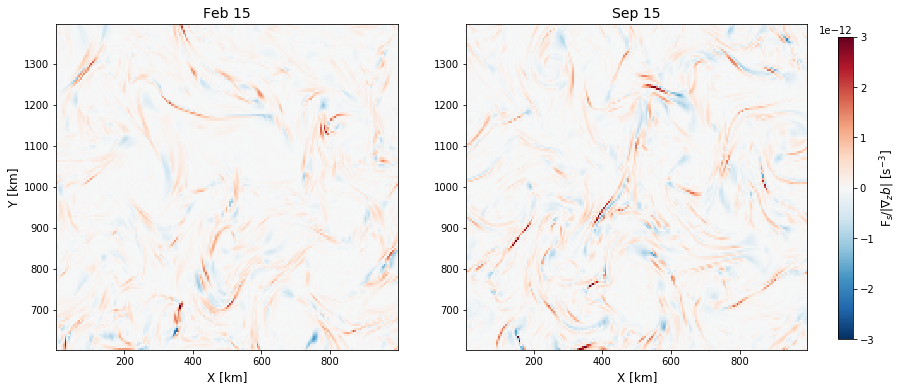

In [33]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
im = ax1.pcolormesh(Fs_normed.XC*1e-3, Fs_normed.YC*1e-3, Fs_normed[-24:,1][3],
                   vmax=3e-12, vmin=-3e-12, cmap='RdBu_r', rasterized=True)

ax2.pcolormesh(Fs_normed.XC*1e-3, Fs_normed.YC*1e-3, Fs_normed[-24:,1][17],
              vmax=3e-12, vmin=-3e-12, cmap='RdBu_r', rasterized=True)

ax1.set_ylabel(r'Y [km]', fontsize=12)
ax1.set_xlabel(r'X [km]', fontsize=12)
# ax2.set_ylabel(r'Y [km]', fontsize=12)
ax2.set_xlabel(r'X [km]', fontsize=12)
ax1.set_title(r"Feb 15",fontsize=14)
ax2.set_title(r"Sep 15",fontsize=14)
fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"F$_s/|\nabla_zb|$ [s$^{-3}$]", fontsize=12)
plt.savefig(op.join(ddir,'Figures/Fs_05km_snap_Feb-Sep.pdf'))

In [36]:
Fs_normed.coords['seas'] = ('time',np.tile(np.repeat(range(4),6),dy))
grouped = (Fs_normed[:,0].sel(YC=slice(6e5,14e5))).groupby('seas')
da = xr.DataArray(np.zeros((4,6*dy,160,200)), dims=['seas','time','YC','XC'],
                  coords={'seas':range(4),'time':range(6*dy),
                         'YC':Fs_normed.YC.data,'XC':Fs_normed.XC.data}
                 )
i = 0
for group in grouped:
#     print(group)
    da[i] = group[1].data
    i += 1
da

<xarray.DataArray (seas: 4, time: 120, YC: 160, XC: 200)>
array([[[[ 2.807497e-10, ..., -1.455629e-09],
         ...,
         [ 4.364228e-10, ...,  2.898553e-09]],

        ...,

        [[-2.132546e-09, ..., -2.635908e-09],
         ...,
         [-6.673935e-10, ..., -2.220026e-11]]],


       ...,


       [[[ 4.253090e-11, ..., -2.889124e-10],
         ...,
         [ 3.674212e-09, ...,  1.617261e-09]],

        ...,

        [[ 2.496924e-09, ..., -8.038354e-09],
         ...,
         [ 1.288994e-10, ..., -1.725984e-09]]]])
Coordinates:
  * seas     (seas) int64 0 1 2 3
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * YC       (YC) >f4 602500.0 607500.0 612500.0 617500.0 622500.0 627500.0 ...
  * XC       (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


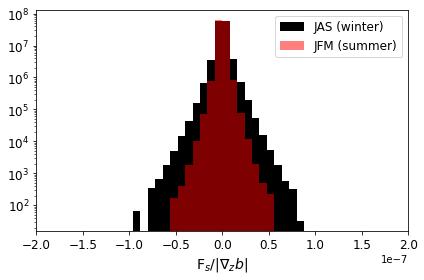

In [38]:
fig, ax = plt.subplots(figsize=(6,4))
fig.set_tight_layout(True)
ax.hist(da[2].data.ravel(), color='black', alpha=1., bins=50, range=(-2e-7,2e-7), 
        log=True, density=True, label='JAS (winter)')
ax.hist(da[0].data.ravel(), color='red', alpha=.5, bins=50, range=(-2e-7,2e-7),
        log=True, density=True, label='JFM (summer)')
ax.set_xlabel(r"F$_s/|\nabla_zb|$", fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ax.set_xlim([-2e-7,2e-7])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(op.join(ddir,'Figures/Fs_histogram_05km.pdf'))

In [26]:
Fs_normed.coords['day'] = ('time',np.tile(range(24),dy))
with ProgressBar():
    Fsd = Fs_normed.sel(YC=slice(6e5,14e5)).groupby('day').mean(['time','YC','XC']).compute()
Fsd

<xarray.DataArray (day: 24, Z: 76)>
array([[ 1.970042e-12,  3.157385e-14,  3.162826e-14, ...,  2.264978e-16,
         1.590964e-16, -5.647532e-15],
       [-2.095487e-12,  3.304250e-14,  3.308615e-14, ...,  2.577303e-16,
         1.605228e-16, -5.548265e-15],
       [ 2.021663e-13,  3.304857e-14,  3.309070e-14, ...,  2.299959e-16,
         1.576665e-16, -5.668778e-15],
       ...,
       [ 9.068841e-12,  3.147761e-14,  3.157426e-14, ...,  1.832904e-16,
         1.378894e-16, -5.697188e-15],
       [ 2.464557e-12,  3.032730e-14,  3.041297e-14, ...,  2.543560e-16,
         1.622479e-16, -5.328101e-15],
       [ 3.518183e-12,  3.154086e-14,  3.161904e-14, ...,  2.215616e-16,
         1.466461e-16, -5.482037e-15]])
Coordinates:
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * day      (day) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

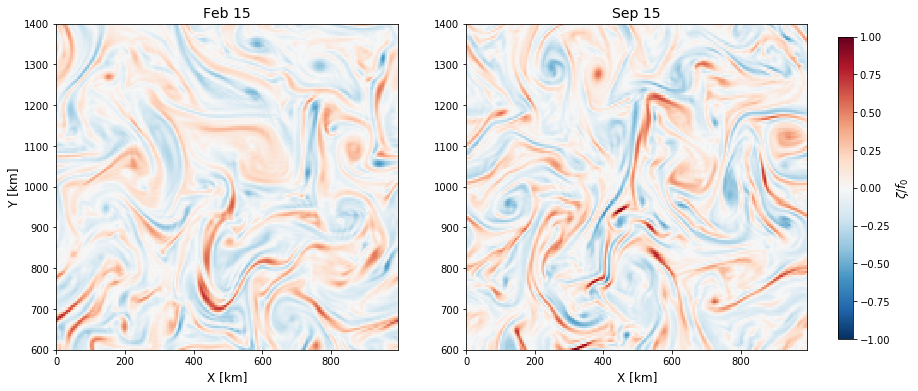

In [23]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
im = ax1.pcolormesh(zeta.XG*1e-3, zeta.YG.sel(YG=slice(6e5,14e5))*1e-3, 
                   zeta[-24:][3,0].sel(YG=slice(6e5,14e5))*f0**-1,
                   vmax=1e0, vmin=-1e0, cmap='RdBu_r', rasterized=True)

ax2.pcolormesh(zeta.XG*1e-3, zeta.YG.sel(YG=slice(6e5,14e5))*1e-3, 
              zeta[-24:][17,0].sel(YG=slice(6e5,14e5))*f0**-1,
              vmax=1e0, vmin=-1e0, cmap='RdBu_r', rasterized=True)

ax1.set_ylabel(r'Y [km]', fontsize=12)
ax1.set_xlabel(r'X [km]', fontsize=12)
# ax2.set_ylabel(r'Y [km]', fontsize=12)
ax2.set_xlabel(r'X [km]', fontsize=12)
ax1.set_title(r"Feb 15",fontsize=14)
ax2.set_title(r"Sep 15",fontsize=14)
fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"$\zeta/f_0$", fontsize=12)
plt.savefig(op.join(ddir,'Figures/zeta_05km_snap_Feb-Sep.pdf'))

In [22]:
seas = ('time',np.tile(np.repeat(range(4),6),dy))
zeta.coords['seas'] = seas
grouped = (zeta[:,0].sel(YG=slice(6e5,14e5))*f0**-1).groupby('seas')
grouped

In [23]:
da = xr.DataArray(np.zeros((4,6*dy,161,200)), dims=['seas','time','YG','XG'],
                 coords={'seas':range(4),'time':range(6*dy),
                         'YG':zeta.YG.sel(YG=slice(6e5,14e5)).data,'XG':zeta.XG.data}
                 )
i = 0
for group in grouped:
#     print(group)
    da[i] = group[1].data
    i += 1
da

<xarray.DataArray (seas: 4, time: 120, YG: 161, XG: 200)>
array([[[[-0.227871, ..., -0.282888],
         ...,
         [ 0.116511, ...,  0.085413]],

        ...,

        [[-0.207679, ..., -0.202926],
         ...,
         [-0.167917, ..., -0.108286]]],


       ...,


       [[[-0.062222, ..., -0.090703],
         ...,
         [-0.091439, ..., -0.066264]],

        ...,

        [[ 0.184702, ...,  0.297866],
         ...,
         [ 0.064722, ...,  0.146997]]]])
Coordinates:
  * seas     (seas) int64 0 1 2 3
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * YG       (YG) float32 600000.0 605000.0 610000.0 615000.0 620000.0 ...
  * XG       (XG) float32 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


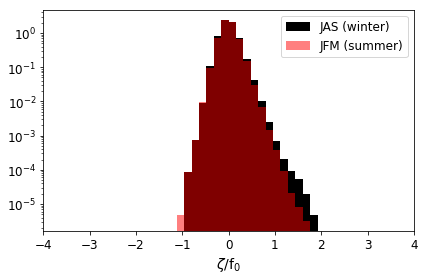

In [24]:
fig, ax = plt.subplots(figsize=(6,4))
fig.set_tight_layout(True)
ax.hist(da[2].data.ravel(), color='black', alpha=1., bins=50, range=(-4,4), 
        log=True, density=True, label='JAS (winter)')
ax.hist(da[0].data.ravel(), color='red', alpha=.5, bins=50, range=(-4,4), 
        log=True, density=True, label='JFM (summer)')
ax.set_xlabel(r"$\zeta$/f$_0$", fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ax.set_xlim([-4,4])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(op.join(ddir,'Figures/zeta_histogram_05km.pdf'))

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


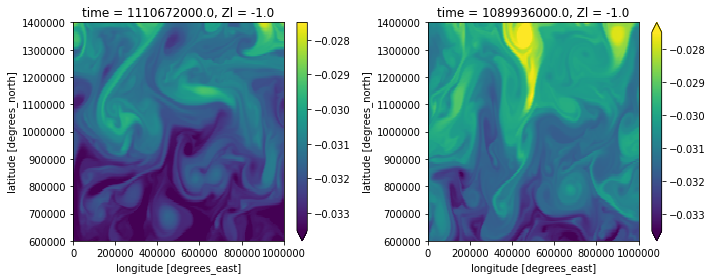

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.set_tight_layout(True)
b[17,1].sel(YC=slice(6e5,14e5)).plot(ax=ax1, vmin=-.0335, vmax=-.0275, rasterized=True)
b[1,1].sel(YC=slice(6e5,14e5)).plot(ax=ax2, vmin=-.0335, vmax=-.0275, rasterized=True)
plt.savefig(op.join(ddir,'Figures/B_Sep15_Jan15.pdf'))

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


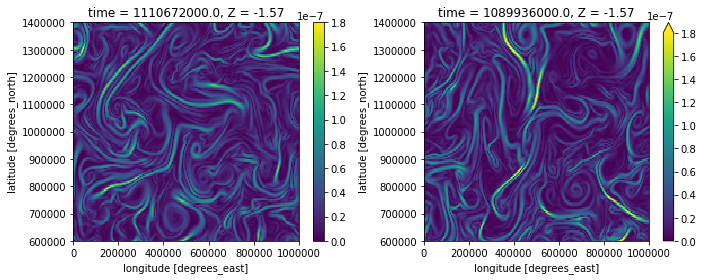

In [65]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.set_tight_layout(True)
ampgradb[17].plot(ax=ax1, vmin=0.e-7, vmax=1.8e-7, rasterized=True)
ampgradb[1].plot(ax=ax2, vmin=0.e-7, vmax=1.8e-7, rasterized=True)
plt.savefig(op.join(ddir,'Figures/gradB_Sep15_Jan15.pdf'))

In [385]:
Fseas = xr.DataArray(np.zeros((4,60,160,200)), dims=['seas','time','YC','XC'],
                    coords={'seas':range(4),'time':range(60),
                           'YC':ampgradb.YC.data,'XC':ampgradb.XC.data}
                    )
grouped = Fs.sel(YC=slice(6e5,14e5)).groupby('seas')
i = 0
for group in grouped:
#     print(group)
    Fseas[i] = group[1].data
    i += 1
Fseas

<xarray.DataArray (seas: 4, time: 60, YC: 160, XC: 200)>
array([[[[ 4.620642e-22, ..., -1.548424e-22],
         ...,
         [ 2.110812e-22, ...,  1.828453e-22]],

        ...,

        [[ 1.301621e-21, ...,  1.638181e-21],
         ...,
         [-1.654649e-21, ...,  9.777514e-21]]],


       ...,


       [[[ 5.375085e-22, ..., -1.855274e-23],
         ...,
         [ 1.389125e-20, ...,  9.195868e-21]],

        ...,

        [[-2.996103e-21, ...,  4.549087e-21],
         ...,
         [ 9.218290e-22, ...,  2.094552e-21]]]])
Coordinates:
  * seas     (seas) int64 0 1 2 3
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * YC       (YC) >f4 602500.0 607500.0 612500.0 617500.0 622500.0 627500.0 ...
  * XC       (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...

(array([1.e+11, 1.e+12, 1.e+13, 1.e+14, 1.e+15, 1.e+16, 1.e+17, 1.e+18,
        1.e+19, 1.e+20, 1.e+21]), <a list of 11 Text yticklabel objects>)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


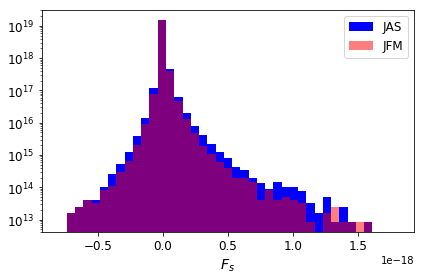

In [395]:
fig, ax = plt.subplots(figsize=(6,4))
fig.set_tight_layout(True)
ax.hist(Fseas[2].data.ravel(), color='blue', bins=41, range=(-.8e-18,1.8e-18), log=True, density=True,
       label=r'JAS')
ax.hist(Fseas[0].data.ravel(), color='red', alpha=0.5, bins=41, range=(-.8e-18,1.8e-18), log=True, density=True,
       label=r'JFM')
ax.set_xlabel(r"$F_s$", fontsize=14)
ax.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [15]:
# ys, dy = (20,10)
# ts = int((ys*360*86400)/3e2+8640)
# te = int(((ys+dy)*360*86400)/3e2+8640)
# print(ts,te)

dsmom = open_mdsdataset(op.join(ddir,'MOM-KPP_05km'), grid_dir=op.join(ddir,'5km_grid'),
                       iters=range(ts+288,te+288,288), prefix=['MOMtave'], delta_t=dt
                       )
# dskpp = open_mdsdataset(op.join(ddir,'MOM-KPP_05km'), grid_dir=op.join(ddir,'5km_grid'),
#                        iters=range(ts+288,te+288,288), prefix=['KPPboundary'], delta_t=dt
#                        )
dsmom

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (XC: 200, XG: 200, YC: 400, YG: 400, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 7200)
Coordinates:
  * XC       (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * YC       (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * XG       (XG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * YG       (YG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * Zp1      (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zu       (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 -16.1 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    rA       (YC, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    dxG      (YG, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    dyG      (YC, XG) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    Depth    (YC

In [38]:
dsmom.coords['days'] = ('time',np.tile(range(360),dy))
with ProgressBar():
    Tday = dsmom.THETA.sel(YC=slice(6e5,14e5)).groupby('days').mean(['time','YC','XC']).compute()
Tday

[########################################] | 100% Completed | 39min  1.5s


<xarray.DataArray 'THETA' (days: 360, Z: 76)>
array([[ 4.174115,  4.17245 ,  4.171504, ..., -0.477167, -0.51317 , -0.517195],
       [ 4.182613,  4.18095 ,  4.180004, ..., -0.477134, -0.513165, -0.517197],
       [ 4.190998,  4.189334,  4.188388, ..., -0.477108, -0.513163, -0.517198],
       ...,
       [ 4.149459,  4.147794,  4.146847, ..., -0.477594, -0.512958, -0.516822],
       [ 4.158135,  4.15647 ,  4.155524, ..., -0.477545, -0.512949, -0.516824],
       [ 4.166739,  4.165075,  4.164129, ..., -0.477495, -0.51294 , -0.516825]],
      dtype=float32)
Coordinates:
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
    drF      (Z) >f4 1.0 1.14 1.3 1.49 1.7 1.93 2.2 2.5 2.84 3.21 3.63 4.1 ...
    PHrefC   (Z) >f4 4.905 15.4017 27.3699 41.05485 56.7018 74.50695 94.7646 ...
  * days     (days) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

In [39]:
Tday.to_dataset(name='Tb').to_netcdf(op.join(ddir,'SSTb_05km.nc'))

In [25]:
fC = f0 + beta*(dsmom.YC-10e5).sel(YC=slice(5.5e5,14.5e5))
fG = f0 + beta*(dsmom.YG-10e5).sel(YG=slice(5.5e5,14.5e5))

In [26]:
grid = Grid(dsmom.sel(YC=slice(6e5,14e5),YG=slice(6e5,14e5)) , periodic=['X'])
grid

<xgcm.Grid>
T Axis (not periodic):
  * center   time (7200)
X Axis (periodic):
  * center   XC (200) --> left
  * left     XG (200) --> center
Y Axis (not periodic):
  * center   YC (160) --> outer
  * outer    YG (161) --> center
Z Axis (not periodic):
  * center   Z (76) --> left
  * left     Zl (76) --> center
  * outer    Zp1 (77) --> center
  * right    Zu (76) --> center

In [27]:
pt = dsmom.THETA.sel(YC=slice(6e5,14e5))   
N2 = alpha*g * (grid.diff(pt,'Z',boundary='extend',to='outer')
               / grid.diff(pt.Z,'Z',boundary='fill',to='outer')               )

In [22]:
# N2.coords['days'] = ('time',np.tile(range(360),dy))

with ProgressBar():
#     N2day = N2.groupby('days').mean(['time','YC','XC']).compute()
    MXLDday = xr.open_dataset(op.join(ddir,'KPPhbl_99percentile_05km.nc')
                             ).hbl99.sel(YC=slice(6e5,14e5)).groupby('day').mean(['time','YC']).compute()

In [24]:
nMLDT = np.argmin(np.abs(np.abs(-pt+pt[:,0])-0.2), axis=1)
zz = xr.DataArray(dsmom.Z.data[np.newaxis,:,np.newaxis,np.newaxis]
                 * np.ones((len(pt.time),len(pt.YC),len(pt.XC)))[:,np.newaxis,:,:],
                 dims=['time','Z','YC','XC'])
MLDT = zz.isel(Z=nMLDT)
MLDT.coords['days'] = ('time',np.tile(range(360),dy))
with ProgressBar():
    MLDTday = MLDT.groupby('days').mean(['time','YC','XC']).compute()

TypeError: unexpected indexer type for VectorizedIndexer: dask.array<nanarg_agg-aggregate, shape=(8280, 160, 200), dtype=int64, chunksize=(1, 160, 200)>

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


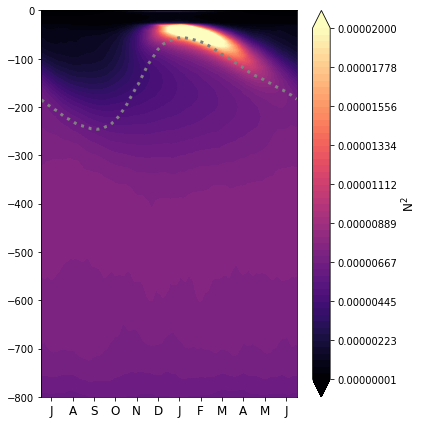

In [22]:
month = ['J','F','M','A','M','J','J','A','S','O','N','D']
fig, ax = plt.subplots(figsize=(6,6))
fig.set_tight_layout(True)
im = ax.contourf(range(360), N2day.Zp1, N2day.roll(days=-180).T,
                levels=1e-5*np.linspace(.001,2,55), extend='both',
#                   vmin=1e-8, vmax=1e-5, 
                cmap='magma')
# ax.plot(range(360), MLDTday.roll(days=-180), color='grey', lw=2)
ax.plot(range(360), -MXLDday.roll(day=-180), color='grey', lw=3, ls=':')
ax.set_ylim([-8e2,0.])
ax.set_xlim([0.,359])
ax.set_xticks(np.linspace(14,344,12))
ax.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"N$^2$", fontsize=12)
plt.savefig(op.join(ddir,'Figures/N2-MXLD_05km.pdf'))

In [ ]:
dsmom.THETA.mean(['time','XC']).to_dataset(name='THETA_clim').to_netcdf(op.join(ddir,'Climatological-theta_05km.nc'))

In [16]:
dsmom.coords['seas'] = ('time',np.tile(np.repeat(range(4),90),dy))
dsmom.coords['months'] = ('time',np.tile(np.repeat(range(12),30),dy))

In [17]:
dmom_seas = dsmom.groupby('seas').mean(['time','XC','XG'])

In [33]:
with ProgressBar():
    dmom_seas.load()
    dclim = dsmom.mean(['time','XC','XG']).load()
dsave_seas

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed |  1hr  9min 58.0s
[#############                           ] | 34% Completed |  2min 29.2s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[###############################         ] | 78% Completed | 28min 43.6s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 53min 31.0s


<xarray.Dataset>
Dimensions:   (YC: 400, YG: 400, Z: 76, Zl: 76, Zp1: 77, Zu: 76, seas: 4)
Coordinates:
  * YC        (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * YG        (YG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * Z         (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * Zp1       (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zu        (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zl        (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    drC       (Zp1) >f4 0.5 1.07 1.22 1.395 1.595 1.815 2.065 2.35 2.67 ...
    drF       (Z) >f4 1.0 1.14 1.3 1.49 1.7 1.93 2.2 2.5 2.84 3.21 3.63 4.1 ...
    PHrefC    (Z) >f4 4.905 15.4017 27.3699 41.05485 56.7018 74.50695 ...
    PHrefF    (Zp1) >f4 0.0 9.81 20.9934 33.7464 48.3633 65.0403 83.9736 ...
  * seas      (seas) int64 0 1 2 3
Data variables:
    UVEL      (seas, Z, YC) float32 0.0 0.007234924 0.008664607 ..

In [18]:
temp_sea = dmom_seas.THETA
temp_sea

<xarray.DataArray 'THETA' (seas: 4, Z: 76, YC: 400)>
dask.array<shape=(4, 76, 400), dtype=float32, chunksize=(1, 76, 400)>
Coordinates:
  * YC       (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
    drF      (Z) >f4 1.0 1.14 1.3 1.49 1.7 1.93 2.2 2.5 2.84 3.21 3.63 4.1 ...
    PHrefC   (Z) >f4 4.905 15.4017 27.3699 41.05485 56.7018 74.50695 94.7646 ...
  * seas     (seas) int64 0 1 2 3

In [18]:
dsnap.coords['seas'] = ('time',np.tile(np.repeat(range(4),6),dy))
# dsnap.coords['months'] = ('time',np.tile(np.repeat(range(12),2),dy))
dsanom = dsnap.groupby('seas') - dmom_seas
# dsanom = dsnap - dsave.mean(['time','XC','XG'])
# dsanomon = dsnap.groupby('months') - dsave_mon
# with ProgressBar():
#     dsanom.load()
#     dsanomon.load()
dsanom

<xarray.Dataset>
Dimensions:  (XC: 200, XG: 200, YC: 400, YG: 400, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 480)
Coordinates:
  * XC       (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * YC       (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * XG       (XG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * YG       (YG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * Zp1      (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zu       (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 -16.1 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    rA       (YC, XC) >f4 25000000.0 25000000.0 25000000.0 25000000.0 ...
    dxG      (YG, XC) >f4 5000.0 5000.0 5000.0 5000.0 5000.0 5000.0 5000.0 ...
    dyG      (YC, XG) >f4 5000.0 5000.0 5000.0 5000.0 5000.0 5000.0 5000.0 ...
    Depth    (YC

In [19]:
# up = dsanom.UVEL
# vp = dsanom.VVEL
wp = dsanom.WVEL
phip = dsanom.PHIHYD

grid = Grid(dsnap, periodic=['X'])
bp = grid.diff(phip,'Z',boundary='fill')/grid.diff(phip.Z,'Z',boundary='fill')
# wpphip = grid.interp(wp,'Z',boundary='fill')*phip
# wpphip_z = grid.diff(wpphip,'Z',boundary='fill')/grid.diff(wpphip.Z,'Z',boundary='fill')
with ProgressBar():
    wpbp = (wp*bp).compute()
# wpphip_z
wpbp

[#                                       ] | 2% Completed |  2min 23.5s


KeyboardInterrupt: 

In [20]:
wp.coords['days'] = ('time', np.tile(range(24),dy))
w2 = ((wp.sel(YC=slice(6e5,14e5))*86400)**2).groupby('days').mean(['time','YC','XC'])
with ProgressBar():
    w2sqrt = np.sqrt(w2).compute()

[########################################] | 100% Completed | 39min 32.2s


In [21]:
# wpbp.coords['days'] = ('time', np.tile(range(24),dy))
# wpbp.to_dataset(name='wpbp').to_netcdf(op.join(ddir,'APEconversion_05km.nc'))
wpbp = xr.open_dataset(op.join(ddir,'APEconversion_05km.nc')).wpbp
with ProgressBar():
    wpbpd = wpbp.sel(YC=slice(6e5,14e5)).groupby('days').mean(['time','YC','XC']).compute()
wpbpd

<xarray.DataArray 'wpbp' (days: 24, Zl: 76)>
array([[-6.880786e-09,  1.356983e-10,  3.282222e-10, ...,  1.074863e-09,
         3.225074e-10,  6.760358e-11],
       [-1.292931e-08,  1.331825e-10,  3.238223e-10, ...,  1.188264e-09,
         3.304327e-10,  6.097706e-11],
       [-1.041988e-08,  1.327336e-10,  3.261422e-10, ...,  1.075167e-09,
         3.038041e-10,  6.217238e-11],
       ...,
       [ 7.199900e-09,  2.712180e-10,  6.109352e-10, ...,  9.698768e-10,
         2.751719e-10,  5.645288e-11],
       [-1.222587e-10,  2.116400e-10,  4.886970e-10, ...,  1.156283e-09,
         3.365692e-10,  6.557394e-11],
       [-6.033010e-09,  1.757232e-10,  4.115716e-10, ...,  1.084706e-09,
         3.039383e-10,  6.162927e-11]], dtype=float32)
Coordinates:
  * Zl       (Zl) float32 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 ...
  * days     (days) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """Initialize the layoutbox for use in constrained_layout."""


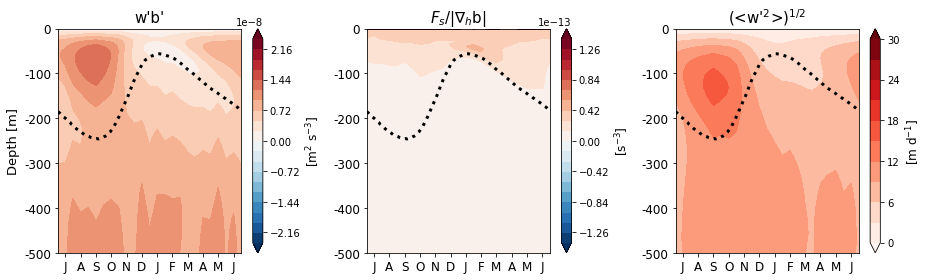

In [36]:
nys, nyn = (6e5,14e5)
month = ['J','F','M','A','M','J','J','A','S','O','N','D']

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(13,4))
fig.set_tight_layout(True)
im1 = ax1.contourf(np.linspace(0,345,24), wpbpd.Zl, wpbpd.T.roll(days=-12), 
                  levels=1e-8*np.linspace(-2.4,2.4,21), 
                   extend='both', cmap='RdBu_r')
ax1.contourf(np.linspace(14,359,24), wpbpd.Zl, wpbpd.T.roll(days=-13), 
            levels=1e-8*np.linspace(-2.4,2.4,21), 
            extend='both', cmap='RdBu_r')
im2 = ax2.contourf(np.linspace(0,345,24), Fsd.Z, Fsd.T.roll(day=-12), 
                  levels=1e-13*np.linspace(-1.4,1.4,21), 
                  cmap='RdBu_r', extend='both')
ax2.contourf(np.linspace(14,359,24), Fsd.Z, Fsd.T.roll(day=-13), 
            levels=1e-13*np.linspace(-1.4,1.4,21), 
            cmap='RdBu_r', extend='both')
im3 = ax3.contourf(np.linspace(0,345,24), w2sqrt.Zl, w2sqrt.T.roll(days=-12), 
                  levels=1e1*np.linspace(0,3.,11), 
                  cmap='Reds', extend='both')
ax3.contourf(np.linspace(14,359,24), w2sqrt.Zl, w2sqrt.T.roll(days=-13), 
            levels=1e1*np.linspace(0,3.,11), 
            cmap='Reds', extend='both')
ax1.plot(range(360), -MXLDday.roll(day=-180), 
        ls=':', lw=3, color='k')
ax2.plot(range(360), -MXLDday.roll(day=-180), 
        ls=':', lw=3, color='k')
ax3.plot(range(360), -MXLDday.roll(day=-180), 
        ls=':', lw=3, color='k')
ax1.set_ylim([-5e2,0])
ax1.set_xlim([0.,359.])
ax2.set_ylim([-5e2,0])
ax2.set_xlim([0.,359.])
ax3.set_ylim([-5e2,0])
ax3.set_xlim([0.,359.])
ax1.set_title(r"w'b'", fontsize=15)
ax2.set_title(r"$F_s/|\nabla_h$b$|$", fontsize=15)
ax3.set_title(r"(<w'$^2$>)$^{1/2}$", fontsize=15)
ax1.set_xticks(np.linspace(14,344,12))
ax1.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
ax2.set_xticks(np.linspace(14,344,12))
ax2.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
ax3.set_xticks(np.linspace(14,344,12))
ax3.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
ax1.set_yticklabels(np.array([-500,-400,-300,-200,-100,0]), fontsize=12)
ax2.set_yticklabels(np.array([-500,-400,-300,-200,-100,0]), fontsize=12)
ax3.set_yticklabels(np.array([-500,-400,-300,-200,-100,0]), fontsize=12)
ax1.set_ylabel(r"Depth [m]", fontsize=13)
# ax2.set_xlabel(r"Month", fontsize=13)
# fig.subplots_adjust(right=0.88)
# cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
# cbar = fig.colorbar(im, cax=cbar_ax)
cbar1 = fig.colorbar(im1, ax=ax1)
cbar2 = fig.colorbar(im2, ax=ax2)
cbar3 = fig.colorbar(im3, ax=ax3)
cbar1.set_label(r"[m$^{2}$ s$^{-3}$]", fontsize=12)
cbar2.set_label(r"[s$^{-3}$]", fontsize=12)
cbar3.set_label(r"[m d$^{-1}$]", fontsize=12)
plt.savefig(op.join(ddir,'Figures/wb-Fs-w2_05km.pdf'))

In [ ]:
with ProgressBar():
    bclim = (grid.diff(dsave.PHIHYD,'Z',boundary='fill')
             /grid.diff(dsave.Z,'Z',boundary='fill')).mean(['time','XC']).compute()
# bclim_hat = xrft.dft(bclim, dim=['XC'])
# bclimx = xr.DataArray(fft.ifft(2j*np.pi*(bclim_hat*bclim_hat.freq_XC).data, axis=-1),
#                      dims=['Z','YC','XC'], coords={'Z':dclim.Z.data,'YC':dclim.YC.data,'XC':dclim.XC.data}
#                      )
bclim.plot(vmax=5e-2)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


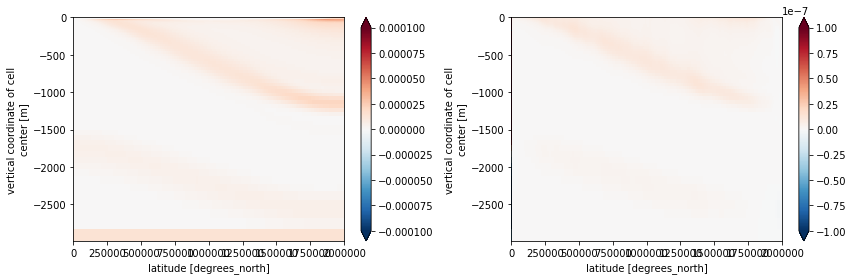

In [187]:
bclimz = grid.diff(bclim,'Z',boundary='fill')/grid.diff(bclim.Zl,'Z',boundary='fill')
bclimy = grid.interp(grid.diff(grid.interp(bclim,'Z',boundary='fill'),'Y',boundary='fill')
                     /grid.diff(bclim.YC,'Y',boundary='fill'),
                    'Y', boundary='fill')
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
fig.set_tight_layout(True)
bclimz.plot(ax=ax1, vmax=1e-4)
bclimy.plot(ax=ax2, vmax=1e-7)

(-1000.0, 0)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


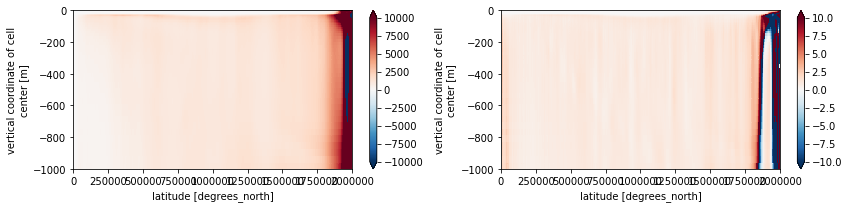

In [126]:
s_b = bclimz/bclimy
vpbp = grid.interp(vp,'Y',boundary='fill')*grid.interp(bp,'Z',boundary='fill')
mu = -(grid.interp(wpbp,'Z',boundary='fill').mean(['time','XC'])
      /vpbp.mean(['time','XC']))*s_b
print(s_b)
print(mu)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
fig.set_tight_layout(True)
s_b.plot(ax=ax1, vmax=1e4)
mu.plot(ax=ax2, vmax=1e1)
ax1.set_ylim([-1e3,0])
ax2.set_ylim([-1e3,0])

/home/takaya/xgcm/xgcm/grid.py:599: RuntimeWarning: invalid value encountered in add
  return 0.5*(data_left + data_right)


(-1000.0, 0)

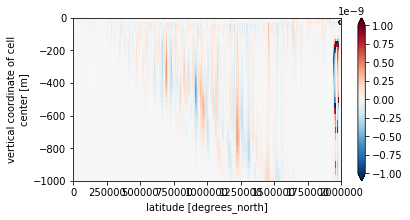

In [151]:
Ddz = (1-mu)*vpbp.mean(['time','XC'])
Ddz = grid.interp(grid.diff(Ddz,'Y',boundary='fill')/grid.diff(Ddz.YC,'Y',boundary='fill'),
                 'Y',boundary='fill')

fig, ax = plt.subplots(figsize=(6,3))
Ddz.plot(ax=ax, vmax=1e-9)
ax.set_ylim([-1e3,0])

In [3]:
# wpbp.to_dataset(name='wpbp').to_netcdf(op.join(ddir,'APEconversion_05km.nc'))
wpbp = xr.open_dataset(op.join(ddir,'APEconversion_05km.nc')).wpbp
wpbp

<xarray.DataArray 'wpbp' (time: 552, Zl: 76, YC: 400, XC: 200)>
[3356160000 values with dtype=float32]
Coordinates:
  * XC       (XC) float32 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 ...
  * YC       (YC) float32 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 ...
  * Zl       (Zl) float32 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 ...
    rA       (YC, XC) float32 ...
    Depth    (YC, XC) float32 ...
    iter     (time) int64 ...
  * time     (time) timedelta64[ns] 12600 days 12615 days 12630 days ...
    seas     (time) int64 ...

In [5]:
# wpphip_z.coords['seas'] = ('time',np.tile(np.repeat(range(4),6),dy))
with ProgressBar():
    wpbp_seas = wpbp.groupby('seas').mean(['time','XC']).compute()
#     wpphip_z_seas = wpphip_z.groupby('seas').mean(['time','XC']).compute()
wpbp_seas

<xarray.DataArray 'wpbp' (seas: 4, Zl: 76, YC: 400)>
array([[[ 0.000000e+00, -1.696221e-08, ..., -1.746144e-08, -1.748067e-08],
        [ 0.000000e+00,  1.233196e-11, ...,  2.679495e-13, -1.713455e-12],
        ...,
        [ 0.000000e+00,  1.852977e-13, ...,  2.086301e-12,  1.048117e-12],
        [ 0.000000e+00,  3.652775e-13, ..., -6.077409e-13, -7.303594e-13]],

       [[ 0.000000e+00, -1.665419e-08, ..., -1.667605e-08, -1.664174e-08],
        [ 0.000000e+00,  1.081247e-11, ...,  7.933817e-12, -8.121851e-12],
        ...,
        [ 0.000000e+00,  1.764922e-13, ..., -1.463189e-13, -2.661350e-12],
        [ 0.000000e+00,  4.195774e-13, ..., -1.580615e-12, -1.613748e-12]],

       [[ 0.000000e+00, -1.615768e-08, ..., -1.824766e-08, -1.828809e-08],
        [ 0.000000e+00,  8.634054e-12, ...,  7.602642e-12, -1.089017e-11],
        ...,
        [ 0.000000e+00,  2.181175e-13, ...,  3.036709e-12,  5.771260e-13],
        [ 0.000000e+00,  3.206449e-13, ..., -4.646193e-13, -6.370377e-13]],

  

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


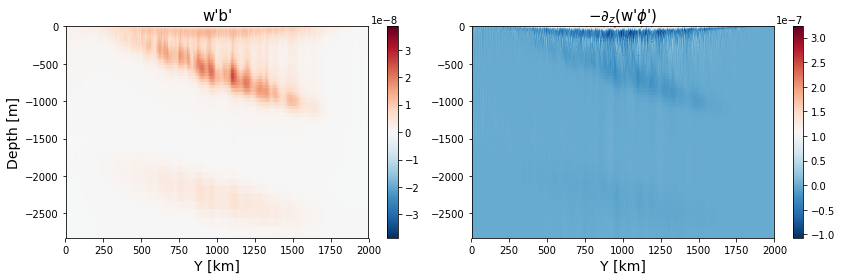

In [35]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
fig.set_tight_layout(True)
im1 = ax1.pcolormesh(wpbp_seas.YC*1e-3, wpbp_seas.Zl, wpbp_seas[2],
#                     vmax=1e1, vmin=1e-1, norm=clr.LogNorm(), 
                     cmap='RdBu_r', rasterized=True)
# ax1.contour(Ttave.YC*1e-3, Ttave.Z, Ttave_seas[2], 
#            levels=np.linspace(-1,8,10))
# ax1.plot(MLD_seas.YC*1e-3, -MLD_seas[2], 'k', lw=2)

im2 = ax2.pcolormesh(wpphip_z_seas.YC*1e-3, wpphip_z_seas.Zl, -wpphip_z_seas[2],
#                     vmax=1e1, vmin=1e-1,
                    cmap='RdBu_r', rasterized=True)
# ax2.contour(Ttave.YC*1e-3, Ttave.Z, Ttave_seas[0], 
#            levels=np.linspace(-1,8,10))
# ax2.plot(MLD_seas.YC*1e-3, -MLD_seas[0], 'k', lw=2)
ax1.set_ylabel(r'Depth [m]', fontsize=14)
ax1.set_xlabel(r'Y [km]', fontsize=14)
ax2.set_xlabel(r'Y [km]', fontsize=14)
ax1.set_title(r"w'b'",fontsize=15)
ax2.set_title(r"$-\partial_z$(w'$\phi$')",fontsize=15)
# fig.subplots_adjust(right=0.87)
# cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
# plt.savefig(op.join(ddir,'Figures/wb_5km_seasclim_JFM-JAS.pdf'))

In [ ]:
# ys, dy = (20,10)
# dt = 3e2
# ts = int((ys*360*86400)/dt+288)
# te = int(((ys+dy)*360*86400)/dt+288)
# print(ts,te)

# dsKPP = open_mdsdataset(op.join(ddir,'MOM-KPP_05km'), grid_dir=op.join(ddir,'5km_grid'),
#                        iters=range(ts+288,te+288,288), prefix=['KPPboundary'], delta_t=dt
#                        )
# dsKPP

In [ ]:
MLD = dsave.MXLDEPTH
MLD.coords['seas'] = ('time',np.tile(np.repeat(range(4),90),dy))
MLD.coords['day'] = ('time',np.tile(range(360),dy))
MLD.coords['month'] = ('time',np.tile(np.repeat(range(12),30),dy))
# MLD.to_dataset(name='mld').to_netcdf(op.join(ddir,'KPPMLD_05km.nc'))
with ProgressBar():
    MLD_clim = MLD.mean(['time','XC']).compute()
    MLD_seas = MLD.groupby('seas').mean(['time','XC']).compute()

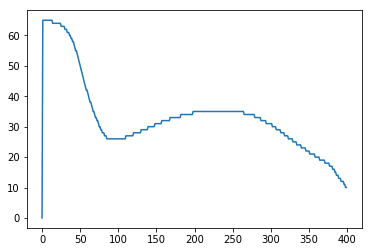

In [180]:
nMLD = np.zeros_like(MLD_clim, dtype=int)
for i in range(len(MLD_clim.YC)):
    nMLD[i] = np.argmin(np.abs(dsave.Z + MLD_clim[i]))
plt.plot(nMLD)

In [174]:
Ddz

<xarray.DataArray (Z: 76, YC: 400)>
array([[          nan,           nan, -5.335633e-04, ...,  7.445211e-05,
         3.463703e-04,  2.910551e-04],
       [          nan,           nan, -2.724113e-11, ...,  1.231898e-10,
         1.446528e-11, -6.213702e-11],
       [          nan,           nan, -2.600779e-11, ...,  9.826488e-11,
        -2.219791e-11, -8.790704e-11],
       ...,
       [          nan,           nan, -1.762154e-14, ..., -8.263030e-14,
         1.585555e-12,  1.132238e-12],
       [          nan,           nan, -3.056643e-14, ...,  1.629603e-13,
         5.436052e-13,  4.669191e-13],
       [          nan,           nan,  1.948422e-11, ...,  8.606195e-12,
         8.700231e-12,  1.705381e-12]], dtype=float32)
Coordinates:
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * YC       (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Warning: converting a masked element to nan.
  This is separate from the ipykernel package so we can avoid doing imports until


(-1e-06, 1e-06)

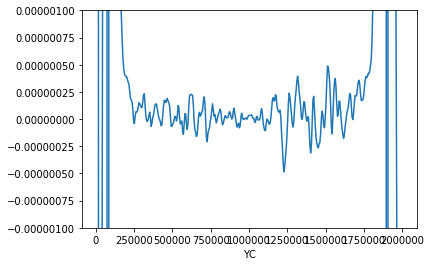

In [183]:
D = np.zeros(nMLD.shape)
for i in range(len(nMLD)):
    D[i] = -np.ma.masked_invalid((Ddz[:,i]*dsave.drF)[:nMLD[i]].data).sum()
D = xr.DataArray(D, dims=['YC'], coords={'YC':dsave.YC.data})
    
fig, ax = plt.subplots()
D.plot(ax=ax)
ax.set_ylim([-1e-6,1e-6])

In [ ]:
hbl = dskpp.KPPhbl
hbl99 = xr.DataArray(np.percentile(hbl, 99, axis=-1), dims=['time','YC'],
                    coords={'time':dsave.time,'YC':dsave.YC})
hbl99

In [ ]:
hbl99.coords['day'] = ('time',np.tile(range(360),dy))
hbl99.coords['seas'] = ('time',np.tile(np.repeat(range(4),90),dy))
hbl99.coords['month'] = ('time',np.tile(np.repeat(range(12),30),dy))
# hbl99.to_dataset(name='hbl99').to_netcdf(op.join(ddir,'KPPhbl_99percentile_05km.nc'))
with ProgressBar():
    hbl99_day = hbl99.groupby('day').mean('time').compute()
    hbl99_sea = hbl99.groupby('seas').mean('time').compute()
    hbl99_mon = hbl99.groupby('month').mean('time').compute()
hbl99_day

In [6]:
# MLD = xr.open_dataset(op.join(ddir,'KPPMLD_05km.nc')).mld
# # MXLD.coords['DinY'] = ('time',np.tile(range(360),5))
# MLD = MLD.groupby('seas').mean(['time'])

MXLD = xr.open_dataset(op.join(ddir,'KPPhbl_99percentile_05km.nc')).hbl99
# MXLD.coords['DinY'] = ('time',np.tile(range(360),5))
hbl99_day = MXLD.groupby('day').mean('time').compute()
MXLD = MXLD.groupby('seas').mean(['time'])
MXLD

<xarray.DataArray 'hbl99' (seas: 4, YC: 400)>
array([[   0.      , 1597.789236, 1581.500953, ...,   30.      ,   30.      ,
          30.      ],
       [   0.      , 1573.951426, 1557.988124, ...,   30.      ,   30.      ,
          30.      ],
       [   0.      , 1586.502679, 1571.821713, ...,   30.      ,   30.      ,
          30.      ],
       [   0.      , 1602.292635, 1585.02885 , ...,   30.      ,   30.      ,
          30.      ]])
Coordinates:
  * YC       (YC) float32 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 ...
  * seas     (seas) int64 0 1 2 3

In [7]:
XLD_clim = xr.open_dataset(op.join(ddir,'KPPhbl_99percentile_05km.nc')).hbl99.mean('time')

In [21]:
with ProgressBar():
    temp_sea.load()

[########################################] | 100% Completed | 25min 42.2s


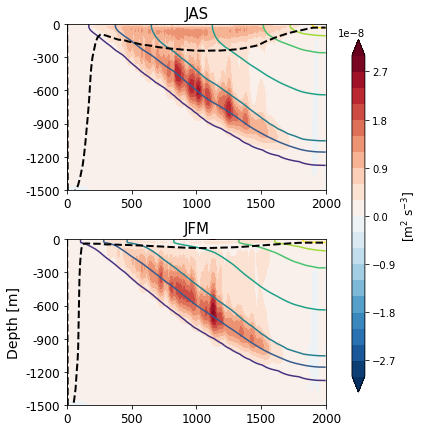

In [48]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,7))
im = ax1.contourf(wpbp_seas.YC*1e-3, wpbp_seas.Zl, wpbp_seas[2],
                 levels=np.linspace(-3e-8,3e-8,21), cmap='RdBu_r', extend='both')
ax1.contour(temp_sea.YC*1e-3, temp_sea.Z, temp_sea[2], 
           levels=np.linspace(-1,8,10))
# ax1.plot(MLD_seas.YC*1e-3, -MLD_seas[2], 'k', lw=2)
ax1.plot(MXLD.YC*1e-3, -MXLD[2], 'k--', lw=2)

ax2.contourf(wpbp_seas.YC*1e-3, wpbp_seas.Zl, wpbp_seas[0],
            levels=np.linspace(-3e-8,3e-8,21), cmap='RdBu_r', extend='both')
ax2.contour(temp_sea.YC*1e-3, temp_sea.Z, temp_sea[0], 
           levels=np.linspace(-1,8,10))
# ax2.plot(MLD_seas.YC*1e-3, -MLD_seas[0], 'k', lw=2)
ax2.plot(MXLD.YC*1e-3, -MXLD[0], 'k--', lw=2)
ax1.set_ylim([-1500,0])
ax2.set_ylim([-1500,0])
ax1.set_xticks(np.array([0,500,1000,1500,2000]))
ax2.set_xticks(np.array([0,500,1000,1500,2000]))
ax1.set_xticklabels(np.array([0,500,1000,1500,2000]), fontsize=12)
ax2.set_xticklabels(np.array([0,500,1000,1500,2000]), fontsize=12)
ax1.set_yticks(np.array([-1500,-1200,-900,-600,-300,0]))
ax2.set_yticks(np.array([-1500,-1200,-900,-600,-300,0]))
ax1.set_yticklabels(np.array([-1500,-1200,-900,-600,-300,0]), fontsize=12)
ax2.set_yticklabels(np.array([-1500,-1200,-900,-600,-300,0]), fontsize=12)
ax2.set_ylabel(r'Depth [m]', fontsize=14)
# ax1.set_xlabel(r'Y [km]', fontsize=14)
# ax2.set_xlabel(r'Y [km]', fontsize=14)
ax1.set_title(r"JAS",fontsize=15)
ax2.set_title(r"JFM",fontsize=15)
fig.subplots_adjust(left=0.2, right=0.8, hspace=0.3)
cbar_ax = fig.add_axes([0.86, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(ddir,'Figures/wb_05km_seasclim_JFM-JAS_2rows.pdf'))

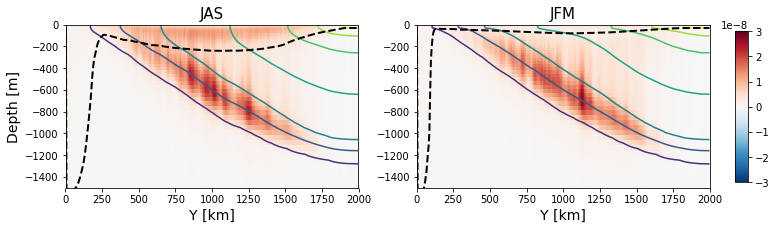

In [43]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
im = ax1.pcolormesh(wpbp_seas.YC*1e-3, wpbp_seas.Zl, wpbp_seas[2],
                   vmax=3e-8, vmin=-3e-8, cmap='RdBu_r', rasterized=True)
ax1.contour(temp_sea.YC*1e-3, temp_sea.Z, temp_sea[2], 
           levels=np.linspace(-1,8,10))
# ax1.plot(MLD_seas.YC*1e-3, -MLD_seas[2], 'k', lw=2)
ax1.plot(MXLD.YC*1e-3, -MXLD[2], 'k--', lw=2)

ax2.pcolormesh(wpbp_seas.YC*1e-3, wpbp_seas.Zl, wpbp_seas[0],
               vmax=3e-8, vmin=-3e-8, cmap='RdBu_r', rasterized=True)
ax2.contour(temp_sea.YC*1e-3, temp_sea.Z, temp_sea[0], 
           levels=np.linspace(-1,8,10))
# ax2.plot(MLD_seas.YC*1e-3, -MLD_seas[0], 'k', lw=2)
ax2.plot(MXLD.YC*1e-3, -MXLD[0], 'k--', lw=2)
ax1.set_ylim([-1500,0])
ax2.set_ylim([-1500,0])
ax1.set_ylabel(r'Depth [m]', fontsize=14)
ax1.set_xlabel(r'Y [km]', fontsize=14)
ax2.set_xlabel(r'Y [km]', fontsize=14)
ax1.set_title(r"JAS",fontsize=15)
ax2.set_title(r"JFM",fontsize=15)
fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig(op.join(ddir,'Figures/wb_05km_seasclim_JFM-JAS.pdf'))

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


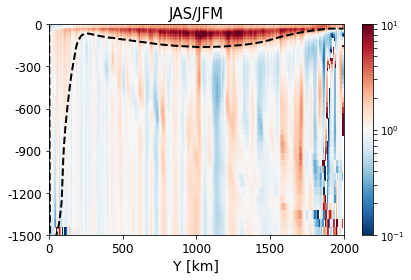

In [50]:
fig, ax = plt.subplots(figsize=(6,4))
fig.set_tight_layout(True)

im = ax.pcolormesh(wpbp_seas.YC*1e-3, wpbp_seas.Zl[:], (wpbp_seas[2]/wpbp_seas[0])[:], 
                  vmin=0.1, vmax=10, norm=clr.LogNorm(), cmap='RdBu_r', rasterized=True
                  )
# ax.plot(MLD_clim.YC*1e-3, -MLD_clim, 'k', lw=2)
ax.plot(XLD_clim.YC*1e-3, -XLD_clim, 'k--', lw=2)

ax.set_ylim([-1500,0])
ax.set_xticks(np.array([0,500,1000,1500,2000]))
ax.set_xticklabels(np.array([0,500,1000,1500,2000]), fontsize=12)
ax.set_yticks(np.array([-1500,-1200,-900,-600,-300,0]))
ax.set_yticklabels(np.array([-1500,-1200,-900,-600,-300,0]), fontsize=12)
# ax.set_ylabel(r'Depth [m]', fontsize=13)
ax.set_xlabel(r'Y [km]', fontsize=14)
ax.set_title(r"JAS/JFM",fontsize=15)

fig.colorbar(im, ax=ax)
plt.savefig(op.join(ddir,'Figures/wb_05km_JFM_JAS.pdf'))

In [46]:
with ProgressBar():
    wkbk = xrft.cross_spectrum(wp.sel(YC=slice(6e5,14e5)).chunk(chunks={'XC':200}),
                              bp.sel(YC=slice(6e5,14e5)).chunk(chunks={'XC':200}),
                              dim=['XC'], detrend='constant', density=False).compute()
#     wk = xrft.dft(wp.sel(YC=slice(6e5,14e5)).chunk(chunks={'XC':200}),
#                  dim=['XC'], detrend='constant').compute()
wkbk

[####                                    ] | 10% Completed |  0.1s

/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:
/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[########################################] | 100% Completed |  1min 56.4s


<xarray.DataArray (time: 552, Zl: 76, YC: 160, freq_XC: 200)>
array([[[[ 8.347188e-10, ...,  9.920452e-11],
         ...,
         [ 2.915427e-10, ..., -2.238301e-10]],

        ...,

        [[ 3.097747e-12, ..., -4.857321e-12],
         ...,
         [ 1.299585e-11, ..., -3.113269e-12]]],


       ...,


       [[[ 5.191116e-11, ...,  7.363453e-11],
         ...,
         [-4.216565e-10, ...,  1.187541e-11]],

        ...,

        [[-4.517200e-11, ..., -4.882622e-13],
         ...,
         [-1.427182e-11, ...,  3.692209e-12]]]])
Coordinates:
  * time             (time) float64 1.089e+09 1.09e+09 1.091e+09 1.093e+09 ...
  * Zl               (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 ...
  * YC               (YC) >f4 602500.0 607500.0 612500.0 617500.0 622500.0 ...
  * freq_XC          (freq_XC) float64 -0.0001 -9.9e-05 -9.8e-05 -9.7e-05 ...
    freq_XC_spacing  float64 1e-06

In [47]:
wkbk.coords['seas'] = ('time',np.tile(np.repeat(range(4),6),dy))
wkbk_seas = wkbk.groupby('seas').mean('time')
wkbk_seas

<xarray.DataArray (seas: 4, Zl: 76, YC: 160, freq_XC: 200)>
array([[[[-4.087461e-11, ..., -8.788021e-12],
         ...,
         [-1.978892e-11, ..., -4.150638e-11]],

        ...,

        [[ 6.472479e-12, ...,  1.078524e-12],
         ...,
         [ 9.264122e-12, ...,  1.038373e-11]]],


       ...,


       [[[ 9.254438e-11, ..., -2.686603e-11],
         ...,
         [-5.030064e-11, ..., -6.520555e-11]],

        ...,

        [[-7.025063e-13, ...,  2.006671e-12],
         ...,
         [ 9.995113e-12, ...,  5.413970e-12]]]])
Coordinates:
  * Zl               (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 ...
  * YC               (YC) >f4 602500.0 607500.0 612500.0 617500.0 622500.0 ...
  * freq_XC          (freq_XC) float64 -0.0001 -9.9e-05 -9.8e-05 -9.7e-05 ...
    freq_XC_spacing  float64 1e-06
  * seas             (seas) int64 0 1 2 3

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/axes/_base.py:3157: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


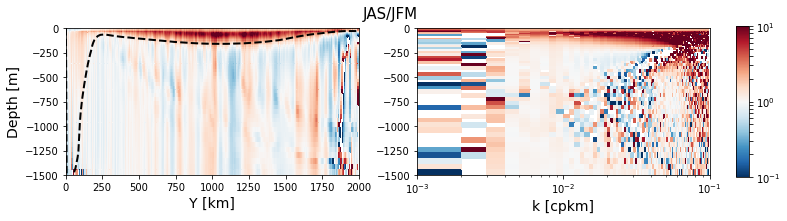

In [49]:
ys = 1e3*np.array([6e2,14e2])

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
# fig.set_tight_layout(True)
im1 = ax1.pcolormesh(wpbp_seas.YC*1e-3, wpbp_seas.Zl[:], (wpbp_seas[2]/wpbp_seas[0])[:], 
                    vmin=.1, vmax=1e1, norm=clr.LogNorm(), cmap='RdBu_r', rasterized=True
                    )
# ax1.plot(MLD_clim.YC*1e-3, -MLD_clim, 'k', lw=2)
ax1.plot(XLD_clim.YC*1e-3, -XLD_clim, 'k--', lw=2)
im2 = ax2.pcolormesh(wkbk_seas.freq_XC[101:]*1e3, wkbk_seas.Zl[:], 
                    (wkbk_seas[2]/wkbk_seas[0]).sel(YC=slice(ys[0],ys[1])).mean('YC')[:,101:], 
                    vmin=.1, vmax=1e1, norm=clr.LogNorm(), cmap='RdBu_r', rasterized=True
                    )
ax1.set_ylabel(r'Depth [m]', fontsize=14)
ax1.set_xlabel(r'Y [km]', fontsize=14)
ax2.set_xscale('log')
ax2.set_xlabel(r'k [cpkm]', fontsize=14)
ax1.set_ylim([-1.5e3,0])
ax2.set_ylim([-1.5e3,0])
ax2.set_xlim([-1e3,1e-1])
fig.subplots_adjust(right=0.87)
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.9, 0.19, 0.015, 0.7])
fig.colorbar(im1, cax=cbar_ax)
fig.suptitle(r'JAS/JFM', fontsize=15)
plt.savefig(op.join(ddir,'Figures/wb_05km_JAS-JFM.pdf'))

In [17]:
w2 = wp**2
w2.coords['seas'] = ('time',np.tile(np.repeat(range(4),6),dy))
with ProgressBar():
    w2_seas = w2.groupby('seas').mean(['time','XC']).compute()

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


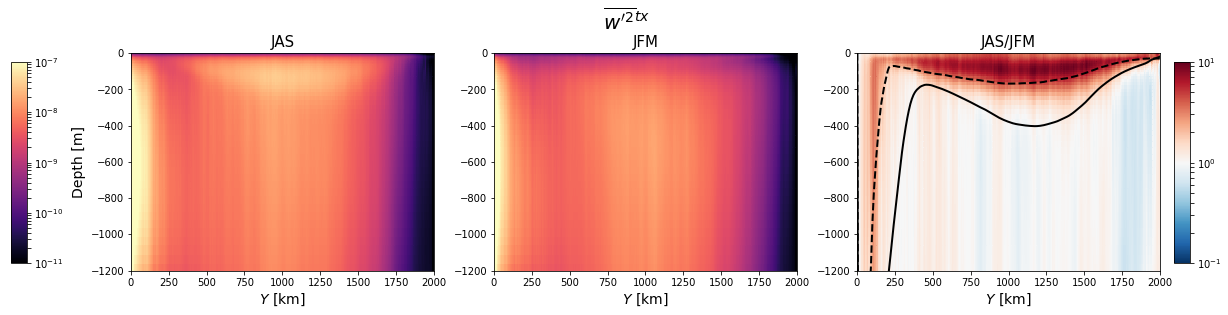

In [18]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(19,4))
# fig.set_tight_layout(True)
im1 = ax1.pcolormesh(w2_seas.YC*1e-3, w2_seas.Zl[:58], w2_seas[2][:58], 
                    vmin=1e-11, vmax=1e-7, norm=clr.LogNorm(), cmap='magma', rasterized=True
                    )
ax2.pcolormesh(w2_seas.YC*1e-3, w2_seas.Zl[:58], w2_seas[0][:58], 
              vmin=1e-11, vmax=1e-7, norm=clr.LogNorm(), cmap='magma', rasterized=True
              )
im3 = ax3.pcolormesh(w2_seas.YC*1e-3, w2_seas.Zl[:58], (w2_seas[2]/w2_seas[0])[:58], 
                    vmin=.1, vmax=1e1, norm=clr.LogNorm(), cmap='RdBu_r', rasterized=True
                    )
ax3.plot(MLD_clim.YC*1e-3, -MLD_clim, 'k', lw=2)
ax3.plot(hbl99.YC*1e-3, -hbl99.mean('time'), 'k--', lw=2)
ax1.set_ylabel(r'Depth [m]', fontsize=14)
ax1.set_xlabel(r'$Y$ [km]', fontsize=14)
ax2.set_xlabel(r'$Y$ [km]', fontsize=14)
ax3.set_xlabel(r'$Y$ [km]', fontsize=14)
ax1.set_ylim([-12e2,0])
ax2.set_ylim([-12e2,0])
ax3.set_ylim([-12e2,0])
ax1.set_title(r"JAS",fontsize=15)
ax2.set_title(r"JFM",fontsize=15)
ax3.set_title(r"JAS/JFM",fontsize=15)
# fig.colorbar(im, ax=ax)
# fig.subplots_adjust(hspace=.8)
fig.subplots_adjust(right=0.89)
fig.subplots_adjust(left=0.138)
cbar_ax1 = fig.add_axes([0.05, 0.15, 0.012, 0.7])
fig.colorbar(im1, cax=cbar_ax1)
cbar_ax3 = fig.add_axes([0.9, 0.15, 0.012, 0.7])
fig.colorbar(im3, cax=cbar_ax3)
fig.suptitle(r"$\overline{w'^2}^{tx}$", fontsize=20, y=1.04)
plt.savefig(op.join(ddir, 'Figures/w2_5km_JAS-JFM.pdf'))

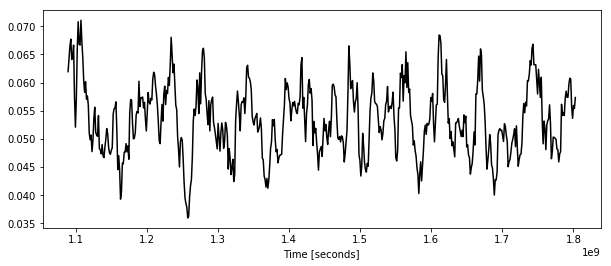

In [103]:
eke = .5 * (grid.interp(up,'X')**2 + grid.interp(vp,'Y',boundary='fill')**2)
(((eke*dsave.drF)[:,:8]).sum('Z')*np.abs(dsave.Zl[8]).data**-1
).sel(YC=slice(6e5,14e5)).mean(['YC','XC']).plot(figsize=(10,4),color='k')

In [104]:
eke.coords['day'] = ('time',np.tile(range(24),dy))
eke.to_dataset(name='eke').to_netcdf(op.join(ddir,'EKE_05km.nc'))

In [11]:
# ys, dy = (20,10)
# ts = int((ys*360*86400)/3e2)
# te = int(((ys+dy)*360*86400)/3e2)
# print(ts,te)
teSF = int(ts + 15*360*86400/dt)
print(teSF)

dsurf = open_mdsdataset(op.join(ddir,'SurfForc_05km'), grid_dir=op.join(ddir,'5km_grid'),
                       iters=range(ts+8640,teSF+8640,8640), prefix=['SurfForc'], delta_t=dt
                       )
dsurf

5184000


/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (XC: 200, XG: 200, YC: 400, YG: 400, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 180)
Coordinates:
  * XC       (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * YC       (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * XG       (XG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * YG       (YG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * Zp1      (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zu       (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 -16.1 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    rA       (YC, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    dxG      (YG, XC) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    dyG      (YC, XG) >f4 dask.array<shape=(400, 200), chunksize=(400, 200)>
    Depth    (YC,

In [119]:
dsurf.TFLUX.attrs

OrderedDict([('standard_name', 'TFLUX'),
             ('long_name',
              'total heat flux (match heat-content variations), >0 increases theta'),
             ('units', 'W/m^2')])

In [12]:
tau = dsurf.oceTAUX
tau.coords['months'] = ('time',np.tile(range(12),15))
Q = dsurf.TFLUX
Q.coords['months'] = ('time',np.tile(range(12),15))

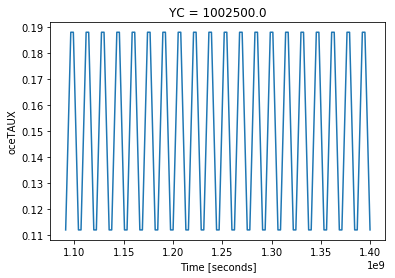

In [28]:
tau.mean('XG')[:,200].plot()

In [13]:
with ProgressBar():
    uk2 = xrft.power_spectrum(grid.interp(up,'X').sel(YC=slice(6e5,1.4e6)).chunk(chunks={'XC':200}),
                             dim=['XC'], detrend='constant').compute()
    vk2 = xrft.power_spectrum(grid.interp(vp,'Y',boundary='fill').sel(YC=slice(6e5,1.4e6)
                                                                     ).chunk(chunks={'XC':200}),
                             dim=['XC'], detrend='constant').compute()

ekek = uk2 + vk2
ekek

[###                                     ] | 9% Completed |  0.1s

/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[########################################] | 100% Completed |  2min 30.7s
[###                                     ] | 9% Completed |  0.1s

/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[########################################] | 100% Completed |  2min 36.4s


<xarray.DataArray (time: 552, Z: 76, YC: 160, freq_XC: 200)>
array([[[[1.927620e-02, ..., 4.719439e-03],
         ...,
         [7.443912e-04, ..., 4.522935e-04]],

        ...,

        [[1.305856e-07, ..., 1.885946e-08],
         ...,
         [4.882651e-09, ..., 1.322681e-07]]],


       ...,


       [[[2.756265e-02, ..., 1.883242e-02],
         ...,
         [1.464363e-04, ..., 2.208521e-04]],

        ...,

        [[1.325114e-07, ..., 9.126481e-07],
         ...,
         [4.723748e-08, ..., 7.116469e-07]]]])
Coordinates:
  * time             (time) float64 1.089e+09 1.09e+09 1.091e+09 1.093e+09 ...
  * Z                (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 ...
  * YC               (YC) >f4 602500.0 607500.0 612500.0 617500.0 622500.0 ...
  * freq_XC          (freq_XC) float64 -0.0001 -9.9e-05 -9.8e-05 -9.7e-05 ...
    freq_XC_spacing  float64 1e-06

In [87]:
ekek.freq_XC[-100:]*1e3

<xarray.DataArray 'freq_XC' (freq_XC: 100)>
array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019,
       0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029,
       0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036, 0.037, 0.038, 0.039,
       0.04 , 0.041, 0.042, 0.043, 0.044, 0.045, 0.046, 0.047, 0.048, 0.049,
       0.05 , 0.051, 0.052, 0.053, 0.054, 0.055, 0.056, 0.057, 0.058, 0.059,
       0.06 , 0.061, 0.062, 0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069,
       0.07 , 0.071, 0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079,
       0.08 , 0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089,
       0.09 , 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099])
Coordinates:
  * freq_XC          (freq_XC) float64 0.0 1e-06 2e-06 3e-06 4e-06 5e-06 ...
    freq_XC_spacing  float64 1e-06

In [14]:
nk25km = -60
dx = 5e3
eke25 = (ekek[:,:,:,nk25km:]).sum('freq_XC')/dx
# eke30.coords['day'] = ('time',np.tile(range(24),dy))
# eke30d = eke30.groupby('day').mean('time')
eke25

<xarray.DataArray (time: 552, Z: 76, YC: 160)>
array([[[2.594939e-02, 2.708514e-02, ..., 5.512917e-03, 4.829089e-03],
        [2.587650e-02, 2.701527e-02, ..., 5.482554e-03, 4.811766e-03],
        ...,
        [2.707195e-04, 2.330190e-04, ..., 9.748869e-06, 8.291280e-06],
        [2.681140e-04, 2.313620e-04, ..., 1.052629e-05, 8.474772e-06]],

       [[1.868840e-02, 2.063526e-02, ..., 1.723684e-02, 1.399962e-02],
        [1.864546e-02, 2.058176e-02, ..., 1.717173e-02, 1.393759e-02],
        ...,
        [2.893017e-04, 2.344492e-04, ..., 6.776758e-06, 6.874769e-06],
        [2.808666e-04, 2.247716e-04, ..., 5.062277e-06, 5.566019e-06]],

       ...,

       [[5.232197e-03, 4.529062e-03, ..., 1.251050e-02, 1.211324e-02],
        [5.208438e-03, 4.515634e-03, ..., 1.246086e-02, 1.206204e-02],
        ...,
        [1.269750e-04, 1.290059e-04, ..., 4.259850e-05, 3.049484e-05],
        [1.220073e-04, 1.238740e-04, ..., 3.073681e-05, 1.970389e-05]],

       [[2.672153e-02, 2.395748e-02, ..., 1

In [40]:
print(eke25.Z[:22],dsave.Zl[22])

<xarray.DataArray 'Z' (Z: 22)>
array([ -0.5  ,  -1.57 ,  -2.79 ,  -4.185,  -5.78 ,  -7.595,  -9.66 , -12.01 ,
       -14.68 , -17.705, -21.125, -24.99 , -29.345, -34.24 , -39.725, -45.855,
       -52.69 , -60.28 , -68.685, -77.965, -88.175, -99.37 ], dtype=float32)
Coordinates:
  * Z                (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 ...
    freq_XC_spacing  float64 1e-06 <xarray.DataArray 'Zl' ()>
array(-105.22, dtype=float32)
Coordinates:
    Zl       >f4 -105.22
Attributes:
    standard_name:      depth_at_upper_w_location
    long_name:          vertical coordinate of upper cell interface
    units:              m
    positive:           down
    axis:               Z
    c_grid_axis_shift:  -0.5


In [15]:
nz100 = 22
eke_zave = (eke25[:,:nz100]*dsnap.drF[:nz100]).sum('Z') * np.abs(dsnap.Zl[nz100]**-1)
wpbp_zave = (wpbp[:,:nz100]*dsnap.drC[:nz100].data[np.newaxis,:,np.newaxis,np.newaxis]).sum('Zl') * np.abs(dsnap.Z[nz100]**-1)
eke_zave.coords['day'] = ('time',np.tile(range(24),dy))
eke_std = eke_zave.sel(YC=slice(6e5,1.4e6)).mean(['YC']).groupby('day').std('time')
eke_mean = eke_zave.sel(YC=slice(6e5,1.4e6)).groupby('day').mean(['time','YC'])
print(wpbp_zave,eke_std)

<xarray.DataArray (time: 552, YC: 400, XC: 200)>
dask.array<shape=(552, 400, 200), dtype=float32, chunksize=(552, 400, 200)>
Coordinates:
  * XC       (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * YC       (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
    rA       (YC, XC) >f4 25000000.0 25000000.0 25000000.0 25000000.0 ...
    Depth    (YC, XC) >f4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    iter     (time) int64 3628800 3633120 3637440 3641760 3646080 3650400 ...
  * time     (time) float64 1.089e+09 1.09e+09 1.091e+09 1.093e+09 1.094e+09 ...
    seas     (time) int64 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 0 ...
    Z        >f4 -111.6
    drF      >f4 dask.array<shape=(), chunksize=()>
    PHrefC   >f4 dask.array<shape=(), chunksize=()> <xarray.DataArray (day: 24)>
dask.array<shape=(24,), dtype=float64, chunksize=(1,)>
Coordinates:
    freq_XC_spacing  float64 1e-06
    Zl               float32 -105.22
  * day       

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


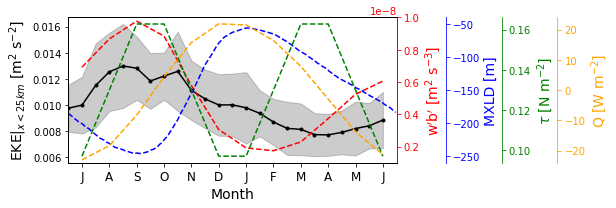

In [22]:
wpbp_zave.coords['month'] = ('time',np.tile(np.repeat(range(12),2),dy))

fig, ax = plt.subplots(figsize=(9,3))
fig.set_tight_layout(True)
ax2 = ax.twinx()
ax3 = ax.twinx()
ax4 = ax.twinx()
ax5 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.15))
ax4.spines["right"].set_position(("axes", 1.32))
ax5.spines["right"].set_position(("axes", 1.49))
im1, = ax.plot(range(0,360,15), eke_mean.roll(day=-12), 'k.-')
ax.fill_between(range(0,360,15), (eke_mean-eke_std).roll(day=-12), 
               (eke_mean+eke_std).roll(day=-12), color='k', alpha=0.2)
im2, = ax2.plot(np.arange(15,360,30),
                wpbp_zave.sel(YC=slice(6e5,1.4e6)).groupby('month').mean(['time','XC','YC']).roll(month=-6), 
                ls='--', color='red')
im3, = ax3.plot(range(360), -hbl99_day.sel(YC=slice(6e5,1.4e6)).mean(['YC']).roll(day=-180), 'b--')
im4, = ax4.plot(range(15,360,30), tau.sel(YC=slice(6e5,1.4e6)).groupby('months').mean(['time','XG','YC']).roll(months=-6),
                'g--')
im5, = ax5.plot(range(15,360,30), Q.sel(YC=slice(6e5,1.4e6)).groupby('months').mean(['time','XC','YC']).roll(months=-6), 
                ls='--', color='orange')

ax2.yaxis.label.set_color(im2.get_color())
ax3.yaxis.label.set_color(im3.get_color())
ax4.yaxis.label.set_color(im4.get_color())
ax5.yaxis.label.set_color(im5.get_color())

ax2.spines["right"].set_edgecolor(im2.get_color())
ax3.spines["right"].set_edgecolor(im3.get_color())
ax4.spines["right"].set_edgecolor(im4.get_color())
ax5.spines["right"].set_edgecolor(im5.get_color())

ax2.tick_params(axis='y', colors=im2.get_color())
ax3.tick_params(axis='y', colors=im3.get_color())
ax4.tick_params(axis='y', colors=im4.get_color())
ax5.tick_params(axis='y', colors=im5.get_color())
ax.set_xticks(range(15,360,30))
ax.set_xlim([0,360])
ax.set_xticklabels(np.roll(['J','F','M','A','M','J','J','A','S','O','N','D'],-6), fontsize=12)
ax.set_xlabel(r'Month', fontsize=14)
ax.set_ylabel(r'EKE$|_{x<25km}$ [m$^2$ s$^{-2}$]', fontsize=14)
ax2.set_ylabel(r"w$'$b$'$ [m$^{2}$ s$^{-3}$]", fontsize=14)
ax3.set_ylabel(r'MXLD [m]', fontsize=14)
ax4.set_ylabel(r'$\tau$ [N m$^{-2}$]', fontsize=14)
ax5.set_ylabel(r'Q [W m$^{-2}$]', fontsize=14)
# ax.set_ylim([0.042,0.06])
ax2.set_ylim([1e-9,10e-9])
ax3.set_ylim([-260,-40])
ax5.set_ylim([-24,24])
plt.savefig(op.join(ddir,'Figures/EKE_wb_XLD_tau_Q_05km.pdf'))

In [3]:
# seas = ('time',np.tile(np.repeat(range(4),6),dy))
# ekek.coords['seas'] = seas
# ekek.to_dataset(name='eke').to_netcdf(op.join(ddir,'EKEk_05kmrun.nc'))
ekek = xr.open_dataset(op.join(ddir,'EKEk_05kmrun.nc')).eke
ekek_seas = ekek.groupby('seas').mean(['time'])
ekek_seas

<xarray.DataArray 'eke' (seas: 4, Z: 76, YC: 160, freq_XC: 200)>
array([[[[5.268972e-03, ..., 3.917333e-03],
         ...,
         [2.993745e-03, ..., 3.086868e-03]],

        ...,

        [[9.270057e-06, ..., 1.140247e-05],
         ...,
         [3.300621e-06, ..., 3.819487e-06]]],


       ...,


       [[[5.903818e-03, ..., 5.946008e-03],
         ...,
         [6.602774e-03, ..., 6.077228e-03]],

        ...,

        [[2.128858e-06, ..., 2.154865e-06],
         ...,
         [1.088231e-05, ..., 1.116892e-05]]]])
Coordinates:
  * Z                (Z) float32 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 ...
  * YC               (YC) float32 602500.0 607500.0 612500.0 617500.0 ...
  * freq_XC          (freq_XC) float64 -0.0001 -9.9e-05 -9.8e-05 -9.7e-05 ...
    freq_XC_spacing  float64 ...
  * seas             (seas) int64 0 1 2 3

In [85]:
ekek_seas.YC

<xarray.DataArray 'YC' (YC: 160)>
array([ 602500.,  607500.,  612500.,  617500.,  622500.,  627500.,  632500.,
        637500.,  642500.,  647500.,  652500.,  657500.,  662500.,  667500.,
        672500.,  677500.,  682500.,  687500.,  692500.,  697500.,  702500.,
        707500.,  712500.,  717500.,  722500.,  727500.,  732500.,  737500.,
        742500.,  747500.,  752500.,  757500.,  762500.,  767500.,  772500.,
        777500.,  782500.,  787500.,  792500.,  797500.,  802500.,  807500.,
        812500.,  817500.,  822500.,  827500.,  832500.,  837500.,  842500.,
        847500.,  852500.,  857500.,  862500.,  867500.,  872500.,  877500.,
        882500.,  887500.,  892500.,  897500.,  902500.,  907500.,  912500.,
        917500.,  922500.,  927500.,  932500.,  937500.,  942500.,  947500.,
        952500.,  957500.,  962500.,  967500.,  972500.,  977500.,  982500.,
        987500.,  992500.,  997500., 1002500., 1007500., 1012500., 1017500.,
       1022500., 1027500., 1032500., 10375

(0.001, 20000.0)

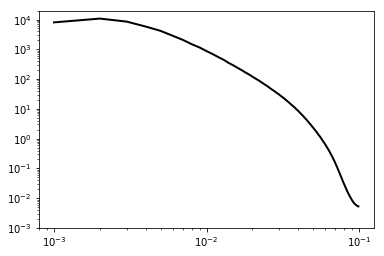

In [4]:
fig, ax = plt.subplots()
ax.plot(ekek.freq_XC[101:]*1e3, ekek[:,0,:,101:].mean(['time','YC']), 'k', lw=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-3,2e4])

In [5]:
ekek05 = xr.open_dataset(op.join(ddir, 'EKEk_05kmrun.nc')).eke
ds1 = xr.open_dataset(op.join(ddir, 'EKEk_20kmrun.nc'))
ds2 = xr.open_dataset(op.join(avisodir, 'JASON2_45-55S_100-150E_JFMekespectra.nc'))
ds3 = xr.open_dataset(op.join(avisodir, 'JASON2_45-55S_100-150E_JASekespectra.nc'))
ekek20 = ds1.eke
ekek05_seas = ekek05.groupby('seas').mean('time')
ekek20_seas = ekek20.groupby('seas').mean('time')
ds4 = xr.open_dataset('/home/takaya/AVISO/AVISO_EKEk_56-61S.nc')
eke_AVISO = ds4.eke.mean('latitude')
k_AVISO = ds4.kx.mean('lat')
N = eke_AVISO.shape
jsn2JFM = ds2.JFM
jsn2JAS = ds3.JAS
kjsn = ds2.kr

print(jsn2JFM, jsn2JAS, kjsn)

<xarray.DataArray 'JFM' (freq_nALONG: 240, nDATA: 1610)>
[386400 values with dtype=float64]
Coordinates:
  * freq_nALONG  (freq_nALONG) float64 -0.5 -0.4958 -0.4917 -0.4875 -0.4833 ...
  * nDATA        (nDATA) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
    kr           (freq_nALONG) float64 ... <xarray.DataArray 'JAS' (freq_nALONG: 240, nDATA: 1646)>
[395040 values with dtype=float64]
Coordinates:
  * freq_nALONG  (freq_nALONG) float64 -0.5 -0.4958 -0.4917 -0.4875 -0.4833 ...
  * nDATA        (nDATA) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
    kr           (freq_nALONG) float64 ... <xarray.DataArray 'kr' (freq_nALONG: 240)>
array([-0.000131, -0.000129, -0.000128, ...,  0.000127,  0.000128,  0.000129])
Coordinates:
  * freq_nALONG  (freq_nALONG) float64 -0.5 -0.4958 -0.4917 -0.4875 -0.4833 ...
    kr           (freq_nALONG) float64 -0.0001306 -0.0001295 -0.0001284 ...


In [72]:
ekek20

<xarray.DataArray 'eke' (time: 240, Z: 20, YC: 40, freq_XC: 50)>
[9600000 values with dtype=float64]
Coordinates:
  * time             (time) float64 2.115e+09 2.116e+09 2.118e+09 2.119e+09 ...
  * Z                (Z) float32 -5.0 -25.0 -49.0 -81.5 -126.0 -187.0 -272.0 ...
  * YC               (YC) float32 610000.0 630000.0 650000.0 670000.0 ...
  * freq_XC          (freq_XC) float64 -2.5e-05 -2.4e-05 -2.3e-05 -2.2e-05 ...
    freq_XC_spacing  float64 ...
    seas             (time) int64 ...

In [6]:
seasAV = np.array([0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,3])
print(len(seasAV))

26


In [7]:
eke_AVISO_yrs = eke_AVISO[:598]
print(eke_AVISO_yrs)
eke_AVISO_yrs.coords['DinY'] = ('days',np.tile(seasAV,23))
eke_AVISO_seas = eke_AVISO_yrs.groupby('DinY').mean('days')
eke_AVISO_seas

<xarray.DataArray 'eke' (days: 598, freq_longitude: 1440)>
array([[2.828993e-10, 3.929395e-10, 4.323431e-10, ..., 3.682711e-10,
        4.323431e-10, 3.929395e-10],
       [3.830729e-10, 3.834541e-10, 4.026887e-10, ..., 4.707198e-10,
        4.026887e-10, 3.834541e-10],
       [3.012153e-10, 4.933155e-10, 5.644254e-10, ..., 4.873114e-10,
        5.644254e-10, 4.933155e-10],
       ...,
       [1.438368e-08, 1.441389e-08, 1.470313e-08, ..., 1.737978e-08,
        1.470313e-08, 1.441389e-08],
       [2.569444e-09, 5.152211e-09, 3.922301e-09, ..., 3.279705e-09,
        3.922301e-09, 5.152211e-09],
       [2.535069e-09, 3.051711e-09, 2.951270e-09, ..., 2.936089e-09,
        2.951270e-09, 3.051711e-09]])
Coordinates:
  * days                    (days) int64 0 14 28 42 56 70 84 98 112 126 140 ...
  * freq_longitude          (freq_longitude) float64 -2.0 -1.997 -1.994 ...
    freq_longitude_spacing  float64 ...


<xarray.DataArray 'eke' (DinY: 4, freq_longitude: 1440)>
array([[4.351772e-10, 4.315060e-10, 4.226446e-10, ..., 4.242275e-10,
        4.226446e-10, 4.315060e-10],
       [4.187558e-10, 4.180976e-10, 4.224793e-10, ..., 4.270869e-10,
        4.224793e-10, 4.180976e-10],
       [3.574422e-09, 3.623521e-09, 3.644584e-09, ..., 3.598471e-09,
        3.644584e-09, 3.623521e-09],
       [4.713173e-09, 4.724282e-09, 4.596361e-09, ..., 4.806354e-09,
        4.596361e-09, 4.724282e-09]])
Coordinates:
  * freq_longitude          (freq_longitude) float64 -2.0 -1.997 -1.994 ...
    freq_longitude_spacing  float64 ...
  * DinY                    (DinY) int64 0 1 2 3

In [30]:
print(ekek10.sel(YC=slice(10e5,12e5)).Z, ekek.sel(YC=slice(10e5,12e5)).Z)

<xarray.DataArray 'Z' (Z: 40)>
array([   -5. ,   -15. ,   -25. ,   -36. ,   -49. ,   -64. ,   -81.5,  -102. ,
        -126. ,  -154. ,  -187. ,  -226. ,  -272. ,  -327. ,  -393. ,  -471.5,
        -565. ,  -667.5,  -770.5,  -873.5,  -976.5, -1079.5, -1182.5, -1285.5,
       -1388.5, -1491.5, -1594.5, -1697.5, -1800.5, -1903.5, -2006.5, -2109.5,
       -2212.5, -2315.5, -2418.5, -2521.5, -2624.5, -2727.5, -2830.5, -2933.5],
      dtype=float32)
Coordinates:
  * Z                (Z) float32 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 ...
    freq_XC_spacing  float64 ... <xarray.DataArray 'Z' (Z: 38)>
array([-5.000000e-01, -2.790000e+00, -5.780000e+00, -9.660000e+00,
       -1.468000e+01, -2.112500e+01, -2.934500e+01, -3.972500e+01,
       -5.269000e+01, -6.868500e+01, -8.817500e+01, -1.116000e+02,
       -1.393650e+02, -1.718250e+02, -2.092350e+02, -2.517700e+02,
       -2.995050e+02, -3.524200e+02, -4.104100e+02, -4.733050e+02,
       -5.409350e+02, -6.131100e+02, -6.896850e+02, -7.705850e

In [52]:
ekek.Z

<xarray.DataArray 'Z' (Z: 76)>
array([-5.000000e-01, -1.570000e+00, -2.790000e+00, -4.185000e+00,
       -5.780000e+00, -7.595000e+00, -9.660000e+00, -1.201000e+01,
       -1.468000e+01, -1.770500e+01, -2.112500e+01, -2.499000e+01,
       -2.934500e+01, -3.424000e+01, -3.972500e+01, -4.585500e+01,
       -5.269000e+01, -6.028000e+01, -6.868500e+01, -7.796500e+01,
       -8.817500e+01, -9.937000e+01, -1.116000e+02, -1.249150e+02,
       -1.393650e+02, -1.549900e+02, -1.718250e+02, -1.899000e+02,
       -2.092350e+02, -2.298550e+02, -2.517700e+02, -2.749850e+02,
       -2.995050e+02, -3.253200e+02, -3.524200e+02, -3.807900e+02,
       -4.104100e+02, -4.412550e+02, -4.733050e+02, -5.065400e+02,
       -5.409350e+02, -5.764650e+02, -6.131100e+02, -6.508550e+02,
       -6.896850e+02, -7.295950e+02, -7.705850e+02, -8.126600e+02,
       -8.558350e+02, -9.001350e+02, -9.455950e+02, -9.922600e+02,
       -1.040180e+03, -1.089425e+03, -1.140080e+03, -1.192235e+03,
       -1.246005e+03, -1.301520

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


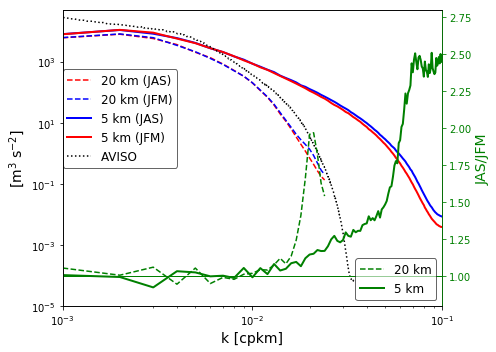

In [8]:
seasons = ['JFM','AMJ','JAS','OND']
colors = ['r','brown','b','g']
g = 9.8
trans = 1.

fig, ax = plt.subplots(figsize=(7,5))
fig.set_tight_layout(True)
ax2 = ax.twinx()
# ax.plot(ekek20.freq_XC[26:]*1e3, ekek20[:,0,:,26:].sel(YC=slice(6e5,14e5)).mean(['time','YC']),
#        'k--', lw=1.5, label='20 km')
ax.plot(ekek20.freq_XC[26:]*1e3, ekek20_seas[0,0,:,26:].sel(YC=slice(6e5,14e5)).mean(['YC']),
       'r--', lw=1.5, alpha=trans, label='20 km (JAS)')
ax.plot(ekek20.freq_XC[26:]*1e3, ekek20_seas[2,0,:,26:].sel(YC=slice(6e5,14e5)).mean(['YC']),
       'b--', lw=1.5, alpha=trans, label='20 km (JFM)')

# ax.plot(ekek.freq_XC[100:]*1e3, ekek[:,0,:,100:].sel(YC=slice(10e5,12e5)).mean(['time','YC'])*ekek.freq_XC[100:]**-1,
#        'k--', lw=2, label='5 km')
# ax.plot(ekek.freq_XC[100:]*1e3, ekek_seas[3,0,:,100:].sel(YC=slice(6e5,14e5)).mean(['YC']),
#        'g', lw=1, label='5 km (OND)')
# ax.plot(ekek.freq_XC[100:]*1e3, ekek_seas[1,0,:,100:].sel(YC=slice(6e5,14e5)).mean(['YC']),
#        color='brown', lw=1, label='5 km (AMJ)')
ax.plot(ekek05.freq_XC[100:]*1e3, ekek05_seas[2,0,:,100:].sel(YC=slice(6e5,14e5)).mean(['YC']),
       'b', lw=2, alpha=trans, label='5 km (JAS)')
ax.plot(ekek05.freq_XC[100:]*1e3, ekek05_seas[0,0,:,100:].sel(YC=slice(6e5,14e5)).mean(['YC']),
       'r', lw=2, alpha=trans, label='5 km (JFM)')
# ax.plot(ekek.freq_XC[100:]*1e3, ekek[:,39,:,100:].sel(YC=slice(6e5,14e5)).mean(['time','YC']),
#        color='k', lw=2, label='5 km (%3d m)' % -ekek.Z[39])
# ax.plot(ekek.freq_XC[100:]*1e3, ekek_seas[2,20,:,100:].sel(YC=slice(10e5,12e5)).mean(['YC'])*ekek.freq_XC[100:]**-1,
#        color='b', alpha=0.6, lw=2, label='5 km (540m)')
# ax.plot(ekek.freq_XC[100:]*1e3, ekek_seas[0,20,:,100:].sel(YC=slice(10e5,12e5)).mean(['YC'])*ekek.freq_XC[100:]**-1,
#        color='r', alpha=0.6, lw=2, label='5 km (540m)')
# ax.plot(ekek.freq_XC[100:]*1e3, ekek[:,26,:,100:].sel(YC=slice(10e5,12e5)).mean(['time','YC'])*ekek.freq_XC[100:]**-1,
#        color='grey', lw=2, label='5 km (1040m)')

# ax.plot(kjsn[121:]*1e3, jsn2JFM.mean('nDATA')[121:]*kjsn*(g/np.abs(gsw.f(-50.)))**2, 
#         'r-.', lw=2, label=r"JASON2 (JFM)")
# ax.plot(kjsn[121:]*1e3, jsn2JAS.mean('nDATA')[121:]*kjsn*(g/np.abs(gsw.f(-50.)))**2, 
#         'b-.', lw=2, label=r"JASON2 (JFM)")
# ax.plot(k_AVISO[20:]*1e3, eke_AVISO[:,int(.5*N[1])+20:].mean('days').data*k_AVISO[20:]**-1,
#        'k:', lw=2, label='AVISO')
ax.plot(k_AVISO[20:]*1e3, eke_AVISO_seas.mean('DinY')[int(.5*N[1])+20:].data*k_AVISO[20:]**-1,
       'k:', alpha=trans, label='AVISO')
# ax.plot(k_AVISO[20:]*1e3, eke_AVISO_seas[0,int(.5*N[1])+20:].data*k_AVISO[20:]**-1,
#        'r:', lw=1., alpha=trans, label='AVISO (JFM)')

ax2.plot(ekek20.freq_XC[26:]*1e3, (ekek20_seas[2,0,:,26:]/ekek20_seas[0,0,:,26:]).sel(YC=slice(6e5,14e5)).mean(['YC']),
        'g--', lw=1.5, label='20 km', alpha=1.)
im, = ax2.plot(ekek05.freq_XC[101:]*1e3, (ekek05_seas[2,0,:,101:]
                                          /ekek05_seas[0,0,:,101:]).sel(YC=slice(6e5,14e5)).mean(['YC']),
              'g', lw=2, label='5 km', alpha=1.)
# ax2.plot(k_AVISO[20:-50][::5]*1e3, (eke_AVISO_seas[2,int(.5*N[1])+20:-50]/eke_AVISO_seas[0,int(.5*N[1])+20:-50])[::5],
#         'g:', lw=1., label='AVISO', alpha=1.)
# ax2.plot(kjsn[121:]*1e3, (jsn2JAS.mean('nDATA') / jsn2JFM.mean('nDATA'))[121:], 
#          'g-.', lw=1., label='JASON2', alpha=1.)
ax2.plot(np.linspace(1e-3,5e-1,10), np.ones(10), 'g', lw=1)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-3,1e-1])
ax.set_ylim([1e-5,5e4])
ax2.set_xscale('log')
ax2.set_ylim([0.8,2.8])
ax2.spines["right"].set_edgecolor(im.get_color())
ax2.yaxis.label.set_color(im.get_color())
ax2.tick_params(axis='y', colors=im.get_color())
ax.set_xlabel(r'k [cpkm]', fontsize=14)
ax.set_ylabel(r'[m$^3$ s$^{-2}$]', fontsize=14)
ax2.set_ylabel(r'JAS/JFM', fontsize=14)
# lg = ax.legend(loc='upper left', fontsize=12, framealpha=.6, frameon=1.)
lg = ax.legend(bbox_to_anchor=(0, .8), loc=2, borderaxespad=0., fontsize=12, framealpha=.6, frameon=1.)
lg2 = ax2.legend(loc='lower right', fontsize=12, framealpha=.6, frameon=1.)
frame = lg.get_frame()
frame.set_color('white')
frame.set_edgecolor('black')
frame2 = lg2.get_frame()
frame2.set_color('white')
frame2.set_edgecolor('black')
# cbar = fig.colorbar(im, ax=ax)
# cbar.set_label(r"[m$^3$ s$^{-2}$]", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig(op.join(ddir,'Figures/EKEkclim_MIT_AVISO.pdf'))

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


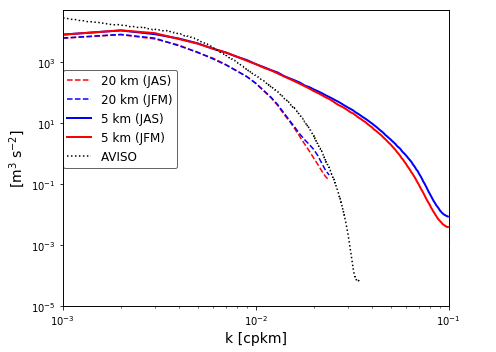

In [28]:
seasons = ['JFM','AMJ','JAS','OND']
colors = ['r','brown','b','g']
g = 9.8
trans = 1.

fig, ax = plt.subplots(figsize=(7,5))
fig.set_tight_layout(True)
ax2 = ax.twinx()
# ax.plot(ekek20.freq_XC[26:]*1e3, ekek20[:,0,:,26:].sel(YC=slice(6e5,14e5)).mean(['time','YC']),
#        'k--', lw=1.5, label='20 km')
ax.plot(ekek20.freq_XC[26:]*1e3, ekek20_seas[0,0,:,26:].sel(YC=slice(6e5,14e5)).mean(['YC']),
       'r--', lw=1.5, alpha=trans, label='20 km (JAS)')
ax.plot(ekek20.freq_XC[26:]*1e3, ekek20_seas[2,0,:,26:].sel(YC=slice(6e5,14e5)).mean(['YC']),
       'b--', lw=1.5, alpha=trans, label='20 km (JFM)')

# ax.plot(ekek.freq_XC[100:]*1e3, ekek[:,0,:,100:].sel(YC=slice(10e5,12e5)).mean(['time','YC'])*ekek.freq_XC[100:]**-1,
#        'k--', lw=2, label='5 km')
# ax.plot(ekek.freq_XC[100:]*1e3, ekek_seas[3,0,:,100:].sel(YC=slice(6e5,14e5)).mean(['YC']),
#        'g', lw=1, label='5 km (OND)')
# ax.plot(ekek.freq_XC[100:]*1e3, ekek_seas[1,0,:,100:].sel(YC=slice(6e5,14e5)).mean(['YC']),
#        color='brown', lw=1, label='5 km (AMJ)')
ax.plot(ekek05.freq_XC[100:]*1e3, ekek05_seas[2,0,:,100:].sel(YC=slice(6e5,14e5)).mean(['YC']),
       'b', lw=2, alpha=trans, label='5 km (JAS)')
ax.plot(ekek05.freq_XC[100:]*1e3, ekek05_seas[0,0,:,100:].sel(YC=slice(6e5,14e5)).mean(['YC']),
       'r', lw=2, alpha=trans, label='5 km (JFM)')
# ax.plot(ekek.freq_XC[100:]*1e3, ekek[:,39,:,100:].sel(YC=slice(6e5,14e5)).mean(['time','YC']),
#        color='k', lw=2, label='5 km (%3d m)' % -ekek.Z[39])
# ax.plot(ekek.freq_XC[100:]*1e3, ekek_seas[2,20,:,100:].sel(YC=slice(10e5,12e5)).mean(['YC'])*ekek.freq_XC[100:]**-1,
#        color='b', alpha=0.6, lw=2, label='5 km (540m)')
# ax.plot(ekek.freq_XC[100:]*1e3, ekek_seas[0,20,:,100:].sel(YC=slice(10e5,12e5)).mean(['YC'])*ekek.freq_XC[100:]**-1,
#        color='r', alpha=0.6, lw=2, label='5 km (540m)')
# ax.plot(ekek.freq_XC[100:]*1e3, ekek[:,26,:,100:].sel(YC=slice(10e5,12e5)).mean(['time','YC'])*ekek.freq_XC[100:]**-1,
#        color='grey', lw=2, label='5 km (1040m)')

# ax.plot(kjsn[121:]*1e3, jsn2JFM.mean('nDATA')[121:]*kjsn*(g/np.abs(gsw.f(-50.)))**2, 
#         'r-.', lw=2, label=r"JASON2 (JFM)")
# ax.plot(kjsn[121:]*1e3, jsn2JAS.mean('nDATA')[121:]*kjsn*(g/np.abs(gsw.f(-50.)))**2, 
#         'b-.', lw=2, label=r"JASON2 (JFM)")
# ax.plot(k_AVISO[20:]*1e3, eke_AVISO[:,int(.5*N[1])+20:].mean('days').data*k_AVISO[20:]**-1,
#        'k:', lw=2, label='AVISO')
# ax.plot(k_AVISO[20:]*1e3, eke_AVISO_seas[2,int(.5*N[1])+20:].data*k_AVISO[20:]**-1,
#        'b:', lw=1., alpha=trans, label='AVISO (JAS)')
# ax.plot(k_AVISO[20:]*1e3, eke_AVISO_seas[0,int(.5*N[1])+20:].data*k_AVISO[20:]**-1,
#        'r:', lw=1., alpha=trans, label='AVISO (JFM)')
ax.plot(k_AVISO[20:]*1e3, eke_AVISO_seas.mean('DinY')[int(.5*N[1])+20:].data*k_AVISO[20:]**-1,
       'k:', alpha=trans, label='AVISO')

# ax2.plot(ekek20.freq_XC[26:]*1e3, (ekek20_seas[2,0,:,26:]/ekek20_seas[0,0,:,26:]).sel(YC=slice(6e5,14e5)).mean(['YC']),
#         'g--', lw=1.5, label='20 km', alpha=0.8)
# im, = ax2.plot(ekek.freq_XC[101:]*1e3, (ekek_seas[2,0,:,101:]/ekek_seas[0,0,:,101:]).sel(YC=slice(6e5,14e5)).mean(['YC']),
#               'g', lw=2, label='5 km', alpha=0.8)
# ax2.plot(k_AVISO[20:-50][::5]*1e3, (eke_AVISO_seas[2,int(.5*N[1])+20:-50]/eke_AVISO_seas[0,int(.5*N[1])+20:-50])[::5],
#         'g:', lw=1., label='AVISO', alpha=0.8)
# ax2.plot(kjsn[121:]*1e3, (jsn2JAS.mean('nDATA') / jsn2JFM.mean('nDATA'))[121:], 
#          'g-.', lw=1., label='JASON2', alpha=0.8)
# ax2.plot(np.linspace(1e-3,5e-1,10), np.ones(10), 'g', lw=1)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-3,1e-1])
ax.set_ylim([1e-5,5e4])
# ax2.set_xscale('log')
# ax2.set_ylim([0.8,2.8])
# ax2.spines["right"].set_edgecolor('white')
ax2.yaxis.label.set_color('white')
ax2.tick_params(axis='y', colors='white')
ax.set_xlabel(r'k [cpkm]', fontsize=14)
ax.set_ylabel(r'[m$^3$ s$^{-2}$]', fontsize=14)
ax2.set_ylabel(r'JAS/JFM', fontsize=14, color='white')
lg = ax.legend(bbox_to_anchor=(0, .8), loc=2, borderaxespad=0., fontsize=12, framealpha=.6, frameon=1.)
# lg = ax.legend(loc='upper left', fontsize=12, framealpha=.6, frameon=1.)
# lg2 = ax2.legend(loc='lower right', fontsize=12, framealpha=.6, frameon=1.)
frame = lg.get_frame()
frame.set_color('white')
frame.set_edgecolor('black')
frame2 = lg2.get_frame()
frame2.set_color('white')
frame2.set_edgecolor('black')
# cbar = fig.colorbar(im, ax=ax)
# cbar.set_label(r"[m$^3$ s$^{-2}$]", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig(op.join(ddir,'Figures/EKEkclim_MIT_AVISO_noRatio.pdf'))

# Growth rates

In [82]:
alpha = 2e-4
g = 9.81
f0 = -1.1e-4
beta = 1.4e-11
f = f0 + beta*(dsave.YC-dsave.YC.mean('YC'))
with ProgressBar():
    N2_seas = alpha*g * (grid.diff(dsave_seas.THETA,'Z',boundary='fill')
                        / grid.diff(dsave_seas.Z,'Z',boundary='fill')
                        ).compute()
N2_seas

<xarray.DataArray (seas: 4, Zl: 76, YC: 400)>
array([[[-0.000000e+00, -2.944952e-03, ..., -3.113831e-02, -3.121284e-02],
        [-0.000000e+00, -2.177569e-06, ...,  3.728193e-04,  3.635678e-04],
        ...,
        [-0.000000e+00,  1.007429e-08, ...,  5.017959e-06,  5.027952e-06],
        [-0.000000e+00,  3.679069e-09, ...,  1.015393e-06,  9.699251e-07]],

       [[-0.000000e+00, -2.933661e-03, ..., -3.098202e-02, -3.113163e-02],
        [-0.000000e+00, -2.219647e-06, ...,  3.705556e-04,  3.674517e-04],
        ...,
        [-0.000000e+00,  1.002800e-08, ...,  5.016889e-06,  5.026270e-06],
        [-0.000000e+00,  3.642933e-09, ...,  1.011231e-06,  9.658801e-07]],

       [[-0.000000e+00, -2.911428e-03, ..., -3.090438e-02, -3.107494e-02],
        [-0.000000e+00, -2.236806e-06, ...,  4.361835e-04,  4.395777e-04],
        ...,
        [-0.000000e+00,  9.950559e-09, ...,  5.024327e-06,  5.032257e-06],
        [-0.000000e+00,  3.579695e-09, ...,  1.015625e-06,  9.703425e-07]],

       [[

<a list of 8 text.Text objects>

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


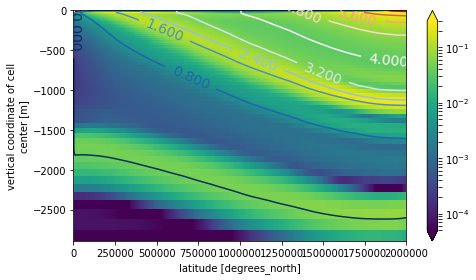

In [89]:
Tclim = xr.open_dataset(op.join(ddir,'Climatological-theta_05km.nc')).THETA_clim
fig, ax = plt.subplots(figsize=(7,4))
fig.set_tight_layout(True)
(N2_seas.mean('seas')*np.abs(f)**-1).plot(ax=ax,vmin=5e-5,vmax=3e-1,norm=clr.LogNorm())
im = Tclim.plot.contour(ax=ax, levels=np.linspace(0,8,11), cmap='RdBu_r')
plt.clabel(im, fontsize=14)

In [90]:
phi_seas = dsave_seas.PHIHYD
ug = -grid.diff(phi_seas,'Y',boundary='fill')/grid.diff(phi_seas.YC,'Y',boundary='fill')
# vg = grid.diff(phi_seas,'X')/grid.diff(phi_seas.XC,'X')
ug = grid.interp(ug,'Y',boundary='fill') * f**-1
ug

<xarray.DataArray (seas: 4, Z: 76, YC: 400)>
array([[[-1.484450e+01, -1.488101e+01, ..., -3.165518e-03, -1.004965e-03],
        [-1.477803e+01, -1.488231e+01, ..., -3.254827e-03, -1.050645e-03],
        ...,
        [ 1.584156e+02, -1.615671e+01, ..., -4.413863e-03, -1.731877e-03],
        [ 1.683789e+02, -1.602777e+01, ..., -3.016669e-03, -1.136048e-03]],

       [[-1.598739e+01, -1.602478e+01, ..., -3.018653e-03, -8.639523e-04],
        [-1.592092e+01, -1.602606e+01, ..., -3.193303e-03, -9.533268e-04],
        ...,
        [ 1.572704e+02, -1.730263e+01, ..., -4.421802e-03, -1.708044e-03],
        [ 1.672336e+02, -1.717373e+01, ..., -2.984915e-03, -1.112215e-03]],

       [[-1.484497e+01, -1.488260e+01, ..., -2.357765e-03, -5.223436e-04],
        [-1.477848e+01, -1.488387e+01, ..., -2.562184e-03, -6.156902e-04],
        ...,
        [ 1.584135e+02, -1.615886e+01, ..., -4.223336e-03, -1.636544e-03],
        [ 1.683766e+02, -1.603000e+01, ..., -2.905529e-03, -1.112215e-03]],

       [[-

In [91]:
MLD = xr.open_dataset(op.join(ddir,'KPPMLD_05km.nc')).mld
with ProgressBar():
    MLD_seas = MLD.groupby('seas').mean(['time','XC']).compute()
MLD_seas

<xarray.DataArray 'mld' (seas: 4, YC: 400)>
array([[   0.      , 1834.475   , 1828.9314  , ...,   19.6828  ,   18.17333 ,
          16.500797],
       [   0.      , 1835.4991  , 1830.5364  , ...,   28.077785,   25.595306,
          22.958374],
       [   0.      , 1838.1066  , 1835.0077  , ...,   28.922066,   26.274923,
          23.58203 ],
       [   0.      , 1842.0089  , 1839.0142  , ...,   20.639265,   19.271814,
          17.816553]], dtype=float32)
Coordinates:
  * YC       (YC) float32 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 ...
  * seas     (seas) int64 0 1 2 3

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


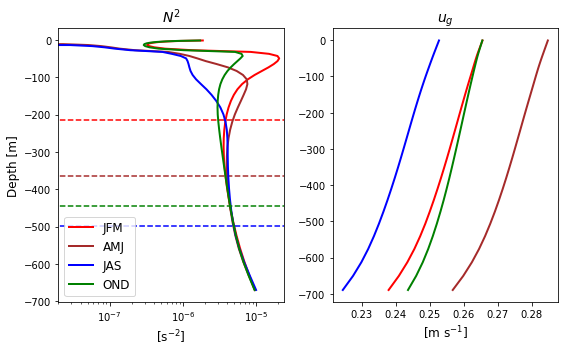

In [96]:
colors = ['red','brown','blue','green']
seasons = ['JFM','AMJ','JAS','OND']

fig, (ax1,ax2) = plt.subplots(figsize=(8,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
for i in range(len(N2_seas.seas)):
    ax1.plot(N2_seas[i,1:45].sel(YC=12.5e5,method='nearest'), dsave.Zl[1:45], color=colors[i], lw=2, label=seasons[i])
    ax1.plot(np.linspace(1e-8,3e-5,5), -np.ones(5)*MLD_seas.sel(YC=12.5e5,method='nearest').data[i], 
             color=colors[i], ls='--')
    ax2.plot(ug[i,:45].sel(YC=12.5e5,method='nearest'), dsave.Z[:45], color=colors[i], lw=2, label=seasons[i])
ax1.set_xlim([2e-8,2.4e-5])
ax1.set_xscale('log')
ax1.set_title(r"$N^2$", fontsize=14)
ax2.set_title(r"$u_g$", fontsize=14)
ax1.set_xlabel(r'[s$^{-2}$]',fontsize=12)
ax2.set_xlabel(r'[m s$^{-1}$]',fontsize=12)
ax1.set_ylabel(r'Depth [m]',fontsize=12)
ax1.legend(loc='lower left', fontsize=12)
plt.savefig(op.join(ddir,'Figures/Background_Ug-N2.pdf'))

In [100]:
kx = np.arange(1e-6,5e-4,5e-7)
nznew = 200
zNew = np.linspace(dsave.Zl[0], dsave.Zl[-1], nznew)
func = pchip(np.abs(dsave.Zl), N2_seas, axis=1)
N2intp = xr.DataArray(func(np.abs(zNew)), dims=['seas','znew','YC'],
                     coords={'seas':N2_seas.seas.data,'znew':zNew,'YC':N2_seas.YC}
                     )
zUew = np.linspace(dsave.Z[0], dsave.Z[-1], nznew)
func = pchip(np.abs(dsave.Z), ug, axis=1)
ugintp = xr.DataArray(func(np.abs(zUew)), dims=['seas','znew','YC'],
                     coords={'seas':range(4),'znew':zNew,'YC':ug.YC}
                     )

In [104]:
kd = np.zeros(4)
kwargs = {'num_eigen': 2, 'init_vector': None, 'num_Lanczos': nznew*10, 'iteration': nznew*100, 'tolerance': 0}
for i in range(len(N2_seas.seas)):
    zf, Rd, neuphi = neu(np.abs(zNew[1:]), N2intp.sel(YC=12.5e5,method='nearest')[i,1:], 
                        np.abs(f0), np.abs(dsave.Zp1.data[-1]),
                        **kwargs
                        )
    kd[i] = (2*np.pi*Rd[1])**-1
kd

/home/takaya/oceanmodes/oceanmodes/baroclinic.py:202: RuntimeWarning: invalid value encountered in power
  Rd = (-w)**-0.5 / np.absolute(f0)


array([1.01487855e-05, 1.01013098e-05, 1.01265385e-05, 1.01239664e-05])

In [105]:
num = 2
omega = np.zeros((len(ug.seas),len(kx), 21), dtype=np.complex128)
# psi = np.zeros((len(ug.seas),len(kx), 11), dtype=np.complex128)
for i in range(len(ug.seas)):
    for j in range(21):
        zpsi, gr, psi = insta(np.abs(zNew[1:]), N2intp.sel(YC=slice(12e5,13.05e5))[i,1:,j], 
                             np.abs(f0), beta, 2*np.pi*kx, np.zeros(1),
                             np.abs(zUew), ugintp.sel(YC=slice(12e5,13.05e5))[i,:,j], np.zeros_like(zUew),
                             np.zeros(2), np.zeros(2), sort='LI', num=num
                             )
        omega[i,:,j] = gr[0,0]

In [107]:
N2h = np.zeros(4)
Ldh = np.zeros(4)
Ri_1h = np.zeros(4)
for i in range(4):
    k=0
    while k < 10:
        if N2_seas.sel(YC=12.5e5,method='nearest')[i,k] >= 0.:
            break
        k += 1
    N2h[i] = (N2_seas[i].sel(YC=12.5e5,method='nearest')
              * np.abs(grid.diff(dsave.Z,'Z',boundary='fill'))
              )[k:].sum('Zl') * np.abs(dsave.Zp1[-1])**-1 
    Ldh[i] = 2*(np.abs(dsave.Zp1.data[-1])*np.sqrt(N2h[i])*np.abs(f0+beta*250*1e3)**-1)
    Ri_1h[i] = (((grid.diff(ug[i],'Z',boundary='fill') / grid.diff(ug.Z,'Z',boundary='fill'))**2
                / N2_seas[i] * dsave.drC.data[:-1,np.newaxis]
                ).sel(YC=12.5e5,method='nearest')
               )[k:].sum('Zl') * np.abs(dsave.Zp1[-1])**-1
    
print(N2h, Ldh, Ri_1h)

mu = np.pi*(kd**-1)[:,np.newaxis] * kx
sigmady = np.abs(f0)*np.sqrt(Ri_1h)[:,np.newaxis] * np.sqrt((np.tanh(.5*mu)**-1 - .5*mu)*(.5*mu - np.tanh(.5*mu)))
sigmady

[3.48754223e-06 3.29721871e-06 3.10259247e-06 3.18054075e-06] [105211.0561947  102299.97326371  99234.80249364 100473.63737193] [0.00018219 0.00030062 0.00032848 0.00012515]


/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


array([[1.30987913e-07, 1.93330345e-07, 2.51932978e-07, ...,
                   nan,            nan,            nan],
       [1.69028980e-07, 2.49438189e-07, 3.24976248e-07, ...,
                   nan,            nan,            nan],
       [1.76259372e-07, 2.60129574e-07, 3.38945416e-07, ...,
                   nan,            nan,            nan],
       [1.08821275e-07, 1.60600796e-07, 2.09258212e-07, ...,
                   nan,            nan,            nan]])

In [ ]:
# # N2ml = np.zeros(4)
# # Ldml = np.zeros(4)
# # Ri_1ml = np.zeros(4)
# # for i in range(4):
# #     nz = np.argmin(np.abs(MLD_seas.isel(YC=125)[i] + N2.Zl))
# #     k=0
# #     while k < 10:
# #         if N2.isel(YC=125)[i,k] >= 0.:
# #             break
# #         k += 1
# #     print(nz.values,k)
# #     N2ml[i] = (N2[i].isel(YC=125)
# #               * np.abs(grid.diff(ds1.Z,'Z',boundary='fill'))
# #               )[k:int(nz)].sum('Zl') * MLD_seas.isel(YC=125)[i]**-1 
# #     Ldml[i] = 2*(MLD_seas.isel(YC=125)[i]*np.sqrt(N2ml[i])*np.abs(f0+beta*250*1e3)**-1)
# #     Ri_1ml[i] = (((grid.diff(ug[i],'Z',boundary='fill') / grid.diff(ug.Z,'Z',boundary='fill'))**2
# #                  / N2[i] * np.abs(grid.diff(ds1.Z,'Z',boundary='fill'))
# #                  ).isel(YC=125)[k:int(nz)]
# #                 ).sum('Zl') * MLD_seas.isel(YC=125)[i]**-1
                
# # print(N2ml, Ldml, Ri_1ml)
# k = 1
# while k < 76:
#     if N2_seas.sel(YC=12.5e5,method='nearest')[0,k] < N2_seas.sel(YC=12.5e5,method='nearest')[2,k]:
#         nz = k
#         break
#     k += 1
# # nz = np.argmin(np.abs(MLD_seas.sel(YC=12.5e5,method='nearest')[0] + N2.Zl)).values
# k=0
# while k < 10:
#     if N2_seas.sel(YC=12.5e5,method='nearest')[2,k] >= 0.:
#         break
#     k += 1
# print(nz,k)
# print(np.abs(N2_seas.Zl.data[nz]), MLD_seas.sel(YC=12.5e5,method='nearest')[0].values)
# N2mlw = (N2_seas[2].sel(YC=12.5e5,method='nearest')
#         * np.abs(grid.diff(ds1.Z,'Z',boundary='fill'))
#         )[(k-1):int(nz+1)].sum('Zl') * np.abs(N2_seas.Zl.data[nz])**-1
# Ldmlw = 2 * (np.abs(N2_seas.Zl.data[nz]) * np.sqrt(N2mlw)
#              * np.abs(f0+beta*250*1e3)**-1
#             )
# Ri_1mlw = (((grid.diff(ug[2],'Z',boundary='fill') / grid.diff(ug.Z,'Z',boundary='fill'))**2
#            / N2_seas[2] * np.abs(grid.diff(ds1.Z,'Z',boundary='fill'))
#            ).sel(YC=12.5e5,method='nearest')[(k-1):int(nz+1)]
#           ).sum('Zl') * np.abs(N2_seas.Zl.data[nz])**-1

# mu = np.pi*Ldmlw.values * kx
# sigmladyw = np.abs(f0)*np.sqrt(Ri_1mlw.values) * np.sqrt((np.tanh(.5*mu)**-1 - .5*mu)*(.5*mu - np.tanh(.5*mu)))
# print(Ldmlw.values)
# print(sigmladyw)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


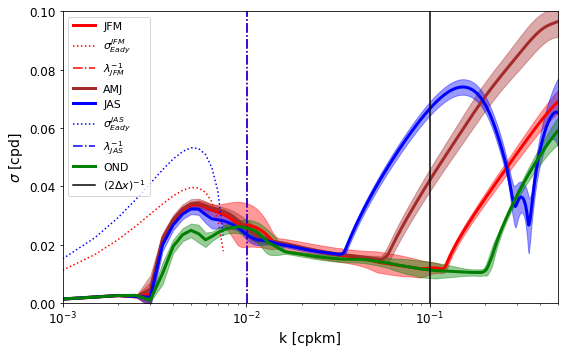

In [113]:
fig, ax = plt.subplots(figsize=(8,5))
fig.set_tight_layout(True)
for i in range(4):
    ax.plot(kx*1e3, omega[i].imag.mean(axis=-1)*86400, 
           color=colors[i], lw=3, label=r'%3s' % seasons[i])
    ax.fill_between(kx*1e3, (omega[i].imag.mean(axis=-1)-omega[i].imag.std(axis=-1))*86400,
                   (omega[i].imag.mean(axis=-1)+omega[i].imag.std(axis=-1))*86400,
                   color=colors[i], alpha=0.4)
    if i==0 or i==2:
        ax.plot(kx*1e3, sigmady[i]*86400, color=colors[i], ls=':',
               label=r'$\sigma^{%3s}_{Eady}$' % seasons[i])
        ax.plot(kd[i]*np.ones(5)*1e3, np.linspace(0.,0.1,5), 
               color=colors[i], ls='-.', label=r'$\lambda^{-1}_{%3s}$' % seasons[i])
#         ax.plot(Ldml[i]**-1*np.ones(5)*1e3, np.linspace(0.,0.08,5), 
#                color=colors[i], ls='-.', label=r'${\lambda^{ML}_{%3s}}^{-1}$' % seasons[i])
# ax.plot(kx*1e3, sigmladyw*86400, color=colors[2], ls='--',
#         label=r'$\sigma_{ML\ Eady}^{%3s}$' % seasons[2])
ax.plot((2*np.diff(dsave.XC)[0])**-1*np.ones(5)*1e3, np.linspace(0.,0.1,5), 
        'k-', label=r'(2$\Delta x$)$^{-1}$')
ax.set_ylim([0.,0.1])
ax.set_xlim([1e-3,5e-1])
ax.set_xscale('log')
ax.set_xlabel(r"k [cpkm]", fontsize=14)
ax.set_ylabel(r"$\sigma$ [cpd]", fontsize=14)
ax.legend(loc='upper left', fontsize=11)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(op.join(ddir,'Figures/Growthrate_dx5km_Y1250km.pdf'))

# Energy budget

The time varying governing equations for a Boussinesq rotating system is
$$\Big(\frac{D{\bf u}}{Dt}\Big)' + f{\bf k}\times{\bf u}' + \frac{1}{\rho_0}\nabla P' = \frac{\bf F'}{\rho_0} + \frac{\bf D'}{\rho_0}$$
$$\frac{\partial P'}{\partial z} = -\rho'g$$
$$\nabla\cdot{\bf u}' + \frac{\partial w'}{\partial z} = 0.$$
Multiplying the third equation with $w'$ and dot producting the first equation with ${\bf u}$ gives
$$\frac{\partial}{\partial z}(w'P') - P'\frac{\partial w'}{\partial z} = -\rho' w' g$$
$${\bf u}'\cdot\Big(\frac{D{\bf u}}{Dt}\Big)' + \nabla\cdot({\bf u}'\phi') - \phi'\nabla\cdot{\bf u}' = \frac{{\bf u}'\cdot {\bf F}'}{\rho_0} + \frac{{\bf u}'\cdot{\bf D'}}{\rho_0}.$$
Using the continuity relation, the equation above becomes
$${\bf u}'\cdot\Big(\frac{D{\bf u}}{Dt}\Big)' + \nabla\cdot({\bf u}'\phi') + \frac{\partial}{\partial z}(w'\phi') - w'\frac{\partial \phi'}{\partial z} = \frac{{\bf u}'\cdot {\bf F}'}{\rho_0} + \frac{{\bf u}'\cdot{\bf D'}}{\rho_0}$$
and with hydrostatic balance and taking the temporal averaging, we get
$$\overline{{\bf u}'\cdot\Big(\frac{D{\bf u}}{Dt}\Big)'} + \nabla\cdot\overline{{\bf u}'\phi'} - \frac{\overline{{\bf u}'\cdot {\bf F}'}}{\rho_0} - \frac{{\bf u}'\cdot{\bf D'}}{\rho_0} = \overline{w'b'} - \frac{\partial}{\partial z}\overline{w'\phi'}.$$

Now, the first term is defined as 
$$\Big(\frac{D{\bf u}}{Dt}\Big)' = \frac{D{\bf u}}{Dt} - \overline{\frac{D{\bf u}}{Dt}}$$
where $\frac{D{\bf u}}{Dt} = \frac{\partial {\bf u}}{\partial t} + {\bf v}\cdot\nabla{\bf u}$.

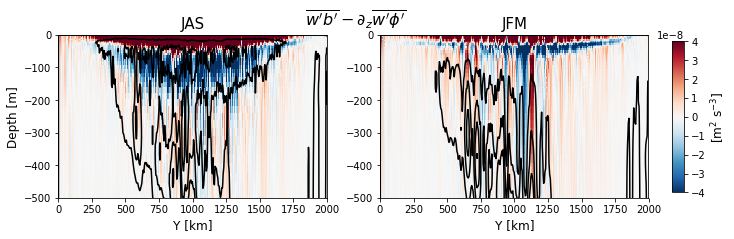

In [236]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,3))
# fig.set_tight_layout(True)
im1 = ax1.pcolormesh(wpphip_z_seas.YC*1e-3, wpphip_z_seas.Zl, wpbp_seas[2]-wpphip_z_seas[2],
                    vmax=4e-8, vmin=-4e-8,
                    cmap='RdBu_r', rasterized=True)
ax1.contour(wpbp_seas.YC*1e-3, wpbp_seas.Zl, wpbp_seas[2],
#                     vmax=1e1, vmin=1e-1, norm=clr.LogNorm(), 
           colors='k', levels=np.linspace(0,4e-8,8))
im2 = ax2.pcolormesh(wpphip_z_seas.YC*1e-3, wpphip_z_seas.Zl, wpbp_seas[0]-wpphip_z_seas[0],
                    vmax=4e-8, vmin=-4e-8,
                    cmap='RdBu_r', rasterized=True)
ax2.contour(wpbp_seas.YC*1e-3, wpbp_seas.Zl, wpbp_seas[0],
#                     vmax=1e1, vmin=1e-1, norm=clr.LogNorm(), 
           colors='k', levels=np.linspace(0,4e-8,8))
ax1.set_ylim([-5e2,0])
ax2.set_ylim([-5e2,0])
ax1.set_title(r"JAS", fontsize=15)
ax2.set_title(r"JFM", fontsize=15)
ax1.set_ylabel(r"Depth [m]", fontsize=12)
ax1.set_xlabel(r"Y [km]", fontsize=12)
ax2.set_xlabel(r"Y [km]", fontsize=12)
fig.suptitle(r"$\overline{w'b'} - \partial_z\overline{w'\phi'}$", fontsize=16, y=1.01)
fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)
# plt.savefig(op.join(ddir,'Figures/wb-wp_z-5km.pdf'))